In [1]:
import numpy
import gzip
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import numba
import copy
import glob
from numba import njit
import pandas
import glob
import psutil
import json
import requests

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 22}
matplotlib.rc('font', **font)

In [2]:
with eua.CDMDataset('/users/staff/uvoggenberger/scratch/humtest/0-20001-0-11035_CEUAS_merged_v1.nc') as file:
    df = file.to_dataframe(groups=['observations_table', 'advanced_homogenisation', 'era5fb'], 
                           variables=['z_coordinate', 'observed_variable', 'observation_value', 'date_time', 'humidity_bias_estimate', 'dew_point_bias_estimate', 'fg_depar@body', 'an_depar@body', 'conversion_method'], 
                          )

In [3]:
for i in df.observed_variable.drop_duplicates():
    print('var',i)
    display(len(df[df.observed_variable == i]))

var 0


21526

var 34


1714

var 39


11559923

var 106


13896710

var 107


13896710

var 117


13010312

var 126


12372045

var 137


11563354

var 138


11713179

var 139


13896710

var 140


13896710

In [4]:
df_rh = df[df.observed_variable == 138]
df_rh['adj_rh'] = df_rh.observation_value - df_rh['humidity_bias_estimate']
df_rh = df_rh.rename(columns={"observation_value": "rh", "conversion_method": "cm_rh"})

df_dp = df[df.observed_variable == 137]
df_dp = df_dp.rename(columns={"observation_value": "dp", "conversion_method": "cm_dp"})

df_ta = df[df.observed_variable == 126]
df_ta = df_ta.rename(columns={"observation_value": "ta"})

In [5]:
new_df = pd.merge(df_rh[['rh', 'adj_rh', 'z_coordinate','date_time','cm_rh']], df_dp[['dp', 'z_coordinate','date_time', 'cm_dp']],  how='left', left_on=['z_coordinate','date_time'], right_on = ['z_coordinate','date_time'])
new_df = pd.merge(new_df, df_ta[['ta', 'z_coordinate','date_time']],  how='left', left_on=['z_coordinate','date_time'], right_on = ['z_coordinate','date_time'])

In [6]:
new_df

,rh,adj_rh,z_coordinate,date_time,cm_rh,dp,cm_dp,ta
0,0.280000,0.280000,4300.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,220.750000
1,0.290000,0.290000,4400.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,220.550003
2,0.280000,0.280000,5300.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,216.250000
3,0.280000,0.280000,9200.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,215.850006
4,0.290000,0.290000,10300.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,220.050003
...,...,...,...,...,...,...,...,...
11713174,0.792027,0.792027,99440.0,2022-12-31 11:30:23,-2147483648,276.320007,-2.147484e+09,279.660004
11713175,0.788326,0.788326,99470.0,2022-12-31 11:30:23,-2147483648,276.390015,-2.147484e+09,279.799988
11713176,0.784618,0.784618,99530.0,2022-12-31 11:30:23,-2147483648,276.440002,-2.147484e+09,279.920013
11713177,0.782605,0.782605,99540.0,2022-12-31 11:30:23,-2147483648,276.529999,-2.147484e+09,280.049988


In [7]:
sys.path.insert(0,os.getcwd()+'/../resort/rasotools-master/')
import rasotools
import xarray as xr
import seaborn
import matplotlib.pylab as plt
import matplotlib.font_manager as font_manager
from matplotlib.pyplot import cm

In [8]:
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
color = cm.rainbow(np.linspace(0, 1, 16))
plev_color = {}
for i in range(len(plevs)):
    plev_color[plevs[i]] = color[i]

In [9]:
d_xtemp=xr.DataArray(new_df.ta)
d_xrelhum=xr.DataArray(new_df.adj_rh)
xpress=xr.DataArray(np.array(new_df.z_coordinate)/100.)

dp_calc = rasotools.met.convert.to_dpd(temp=d_xtemp,press=xpress,rel_humi=d_xrelhum, svp_method='Sonntag', dp_instead_of_dpd=True).values

In [10]:
df_final = copy.copy(new_df)
df_final['adj_dp'] = dp_calc
df_final['dewpoint_bias_estimate'] = df_final['dp'] - df_final['adj_dp']


In [11]:
df_final[np.isin(df_final.z_coordinate, plevs)]

,rh,adj_rh,z_coordinate,date_time,cm_rh,dp,cm_dp,ta,adj_dp,dewpoint_bias_estimate
21,0.580000,0.580000,92500.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,273.250000,265.980011,NaN
69,0.427200,0.427200,40000.0,1949-04-08 03:00:00,-2147483648,NaN,NaN,232.350006,224.520004,NaN
70,0.360000,0.303519,50000.0,1949-04-08 03:00:00,-2147483648,NaN,NaN,239.149994,227.630005,NaN
72,0.430000,0.397597,70000.0,1949-04-08 03:00:00,-2147483648,NaN,NaN,260.149994,249.300003,NaN
75,0.800000,0.767658,85000.0,1949-04-08 03:00:00,-2147483648,NaN,NaN,269.149994,265.690002,NaN
...,...,...,...,...,...,...,...,...,...,...
11712441,0.601593,0.601593,40000.0,2022-12-31 11:30:23,-2147483648,237.929993,-2.147484e+09,243.160004,237.910004,0.019989
11712619,0.877875,0.877875,50000.0,2022-12-31 11:30:23,-2147483648,253.279999,-2.147484e+09,254.800003,253.279999,0.000000
11712891,0.592786,0.592786,70000.0,2022-12-31 11:30:23,-2147483648,265.329987,-2.147484e+09,272.269989,265.339996,-0.010010
11713050,0.724276,0.724276,85000.0,2022-12-31 11:30:23,-2147483648,277.220001,-2.147484e+09,281.899994,277.230011,-0.010010


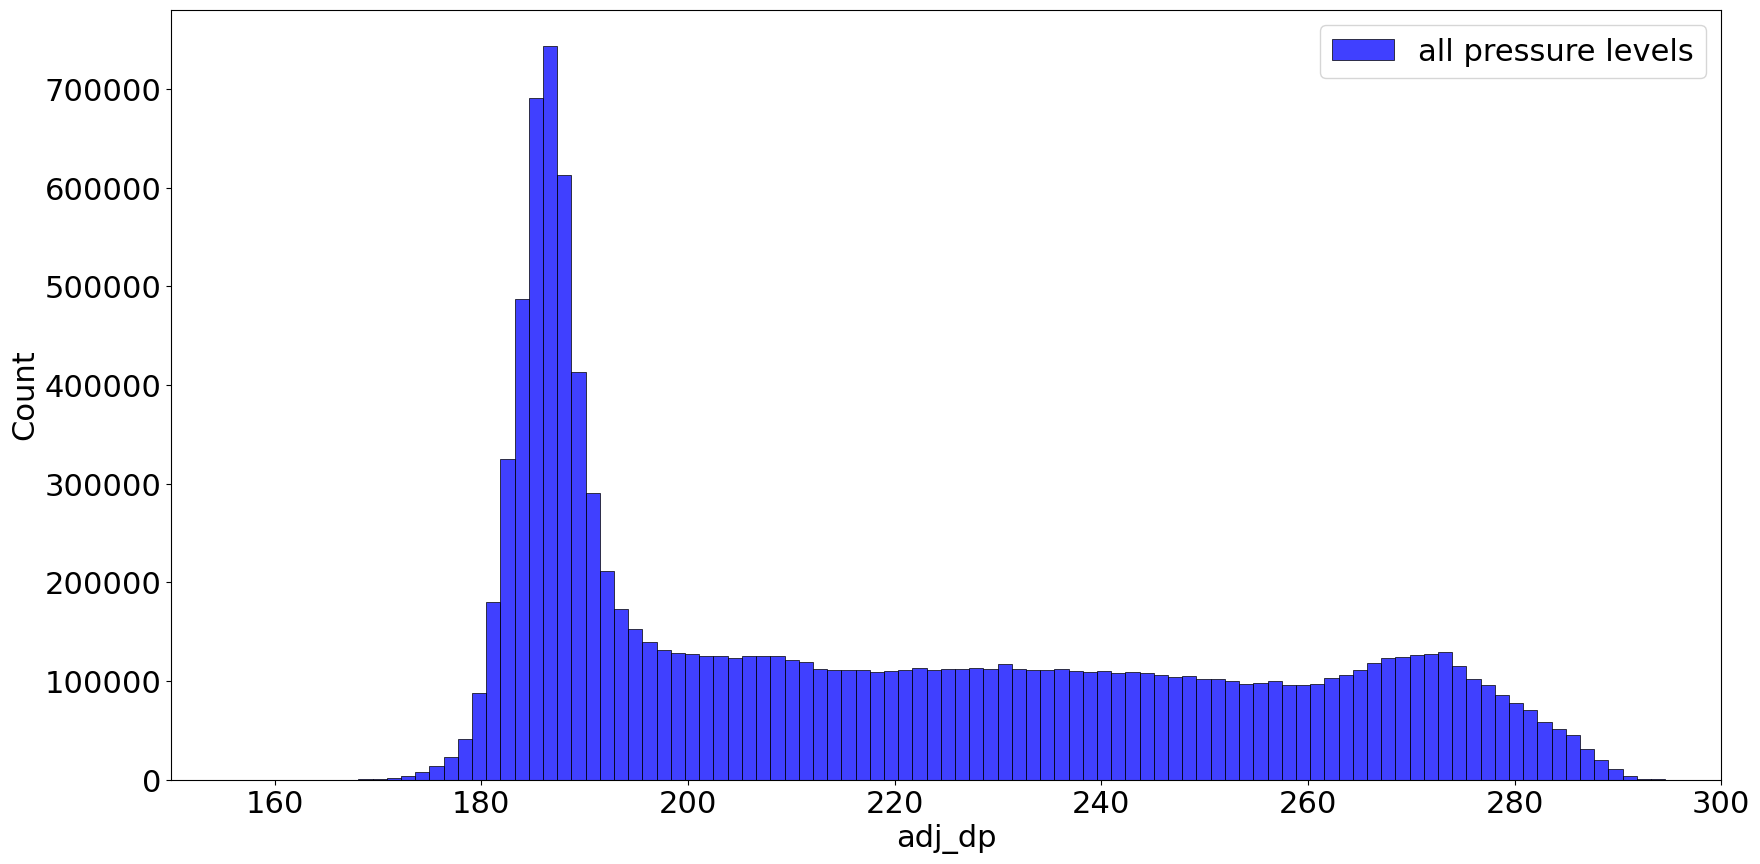

In [49]:
seaborn.histplot(data=df_final, x="adj_dp", label='all pressure levels', bins=200, color='blue', legend=False)
plt.xlim(150, 300)
plt.legend()
plt.show()
plt.close()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


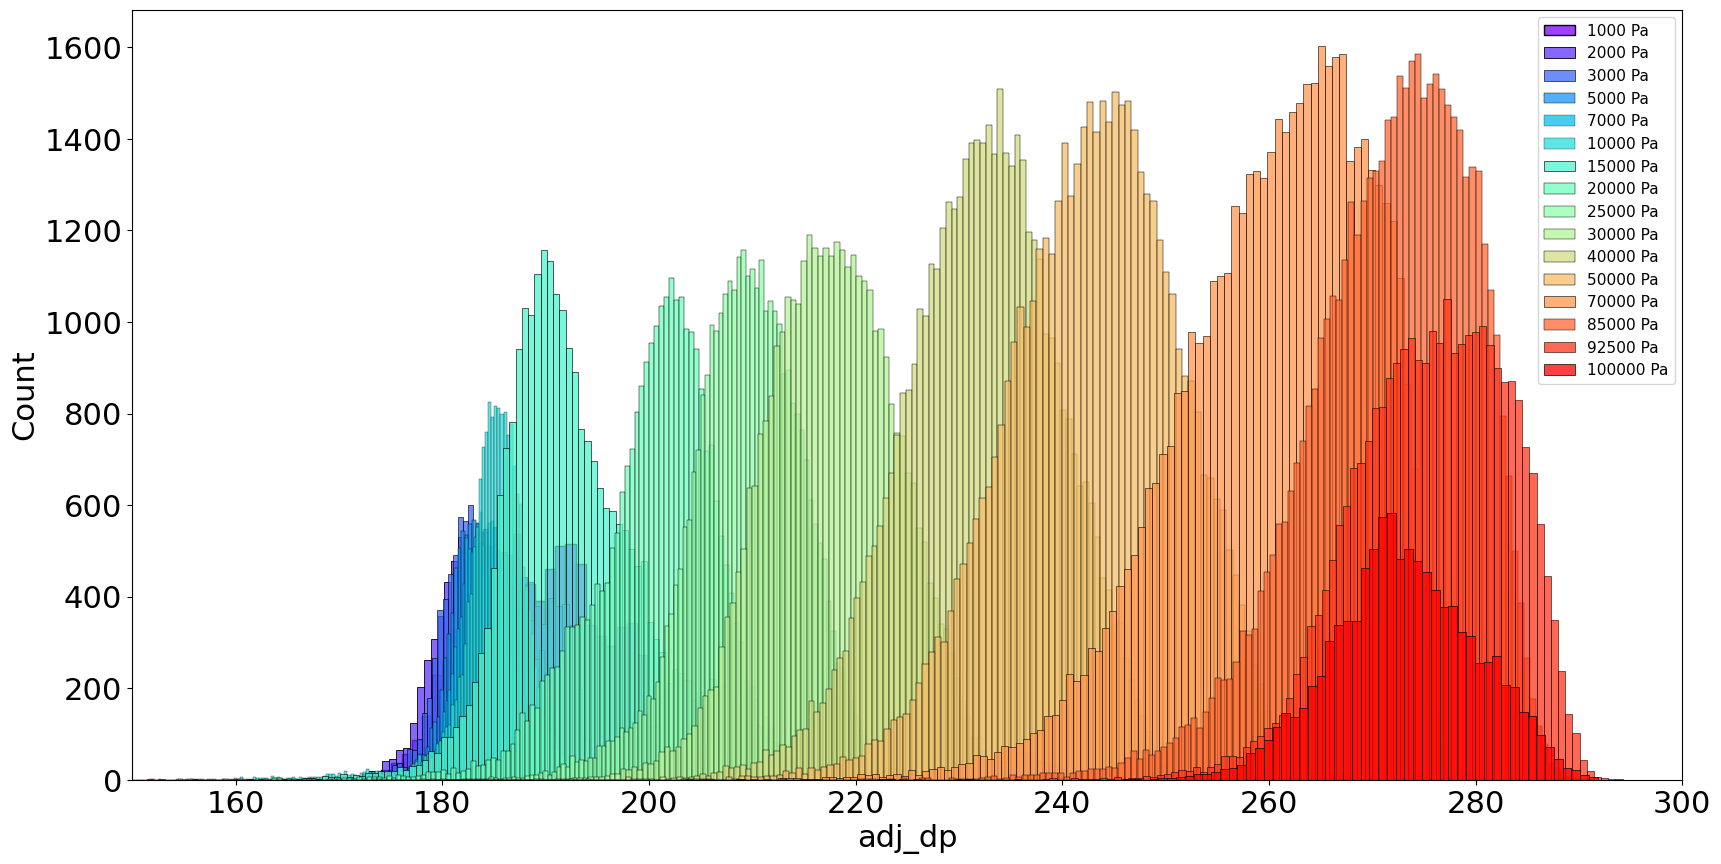

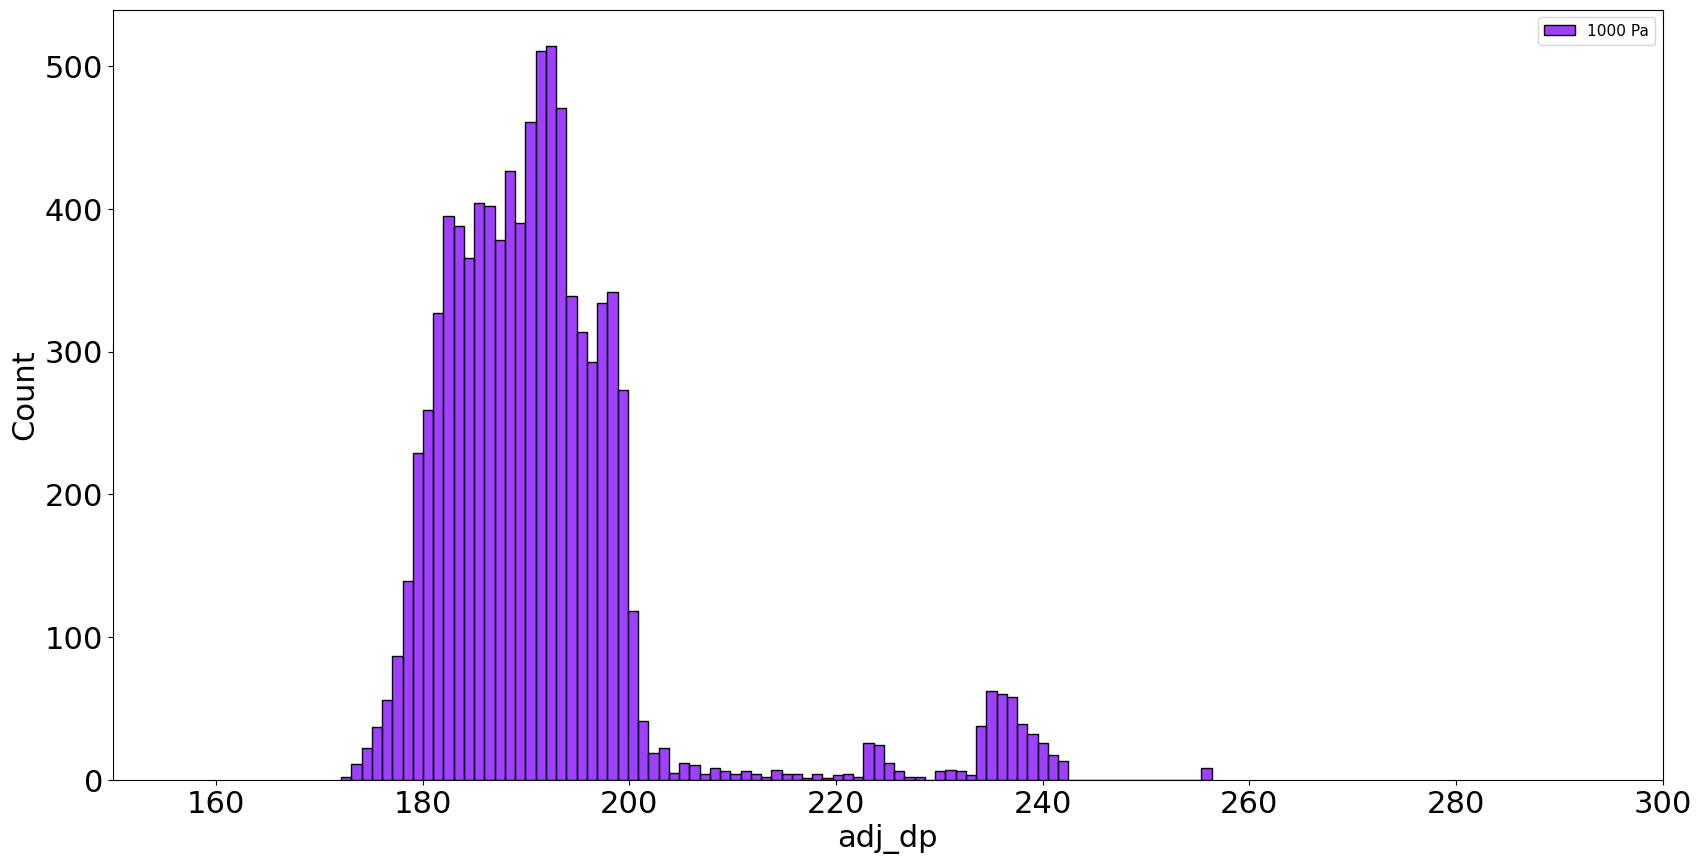

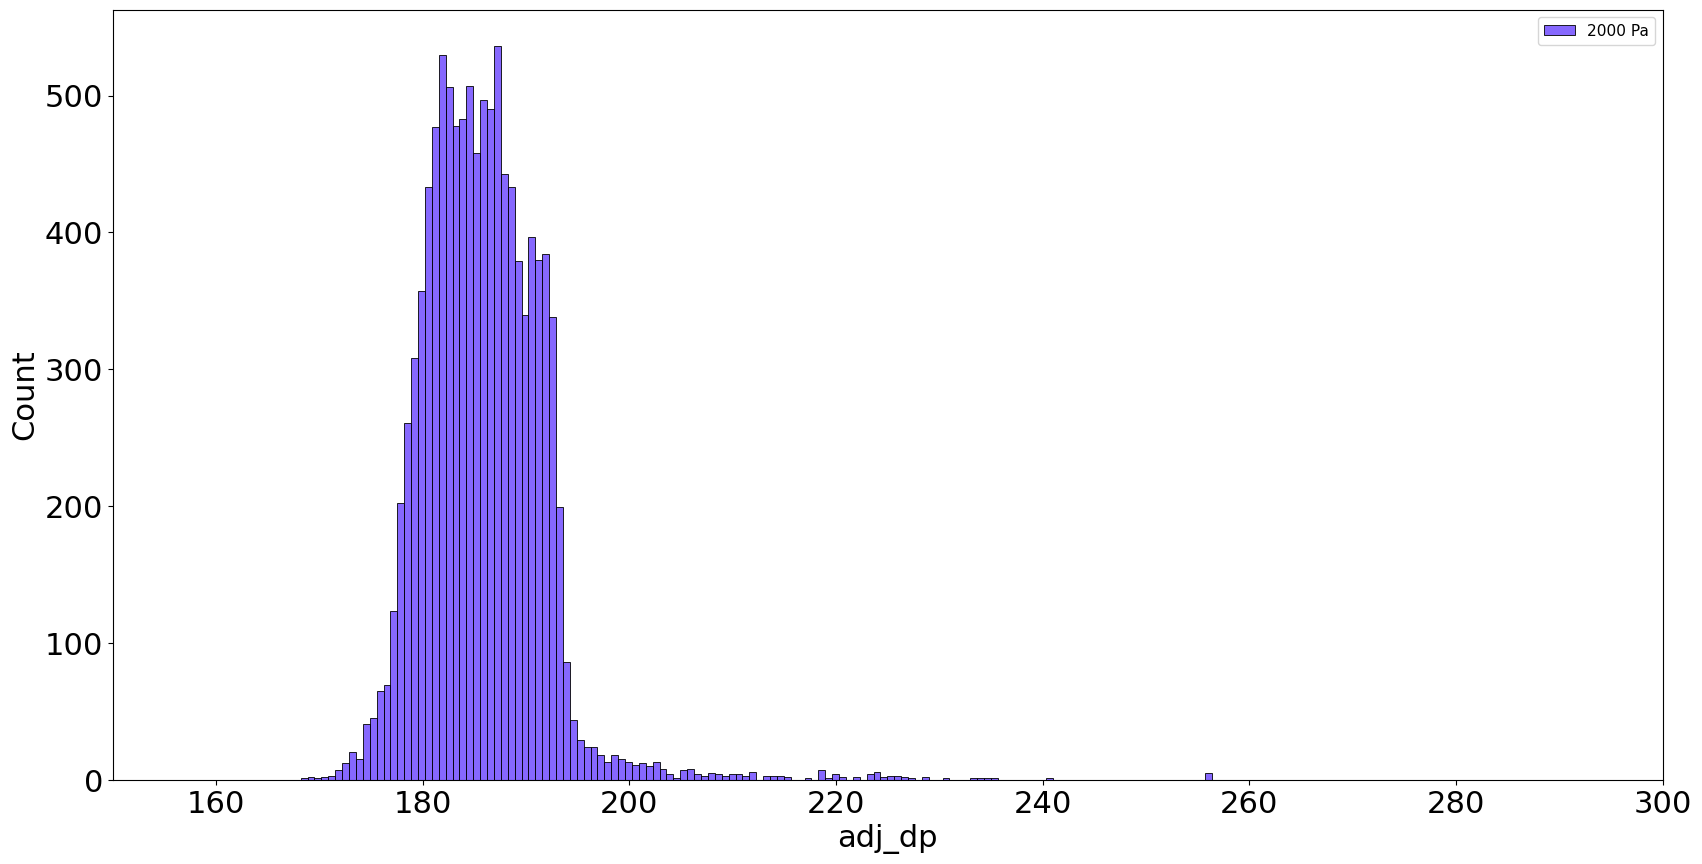

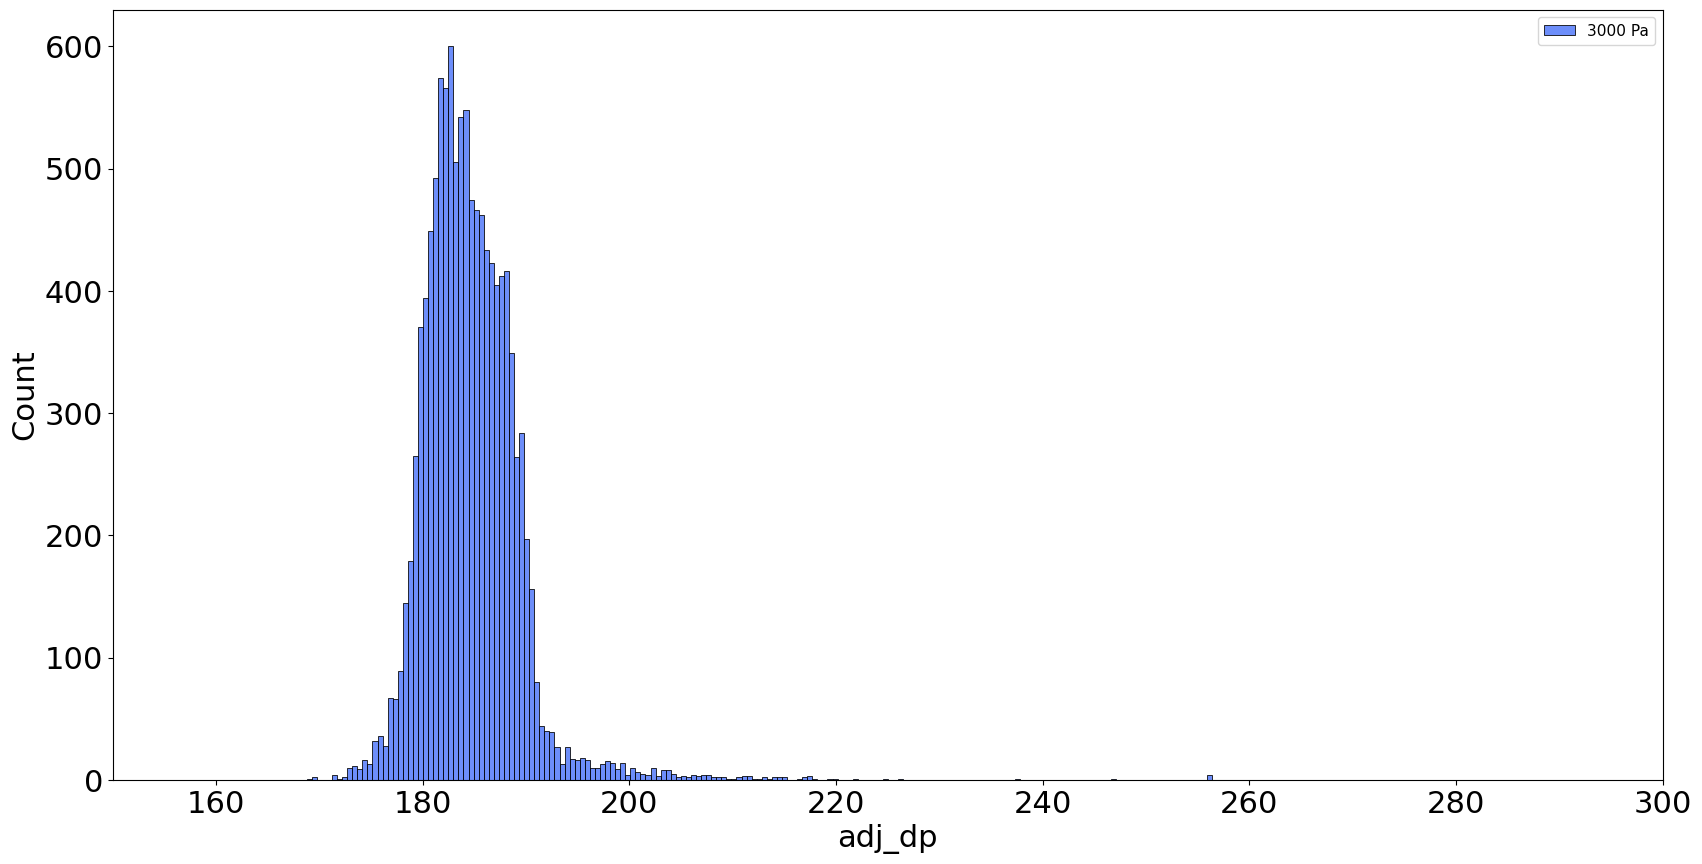

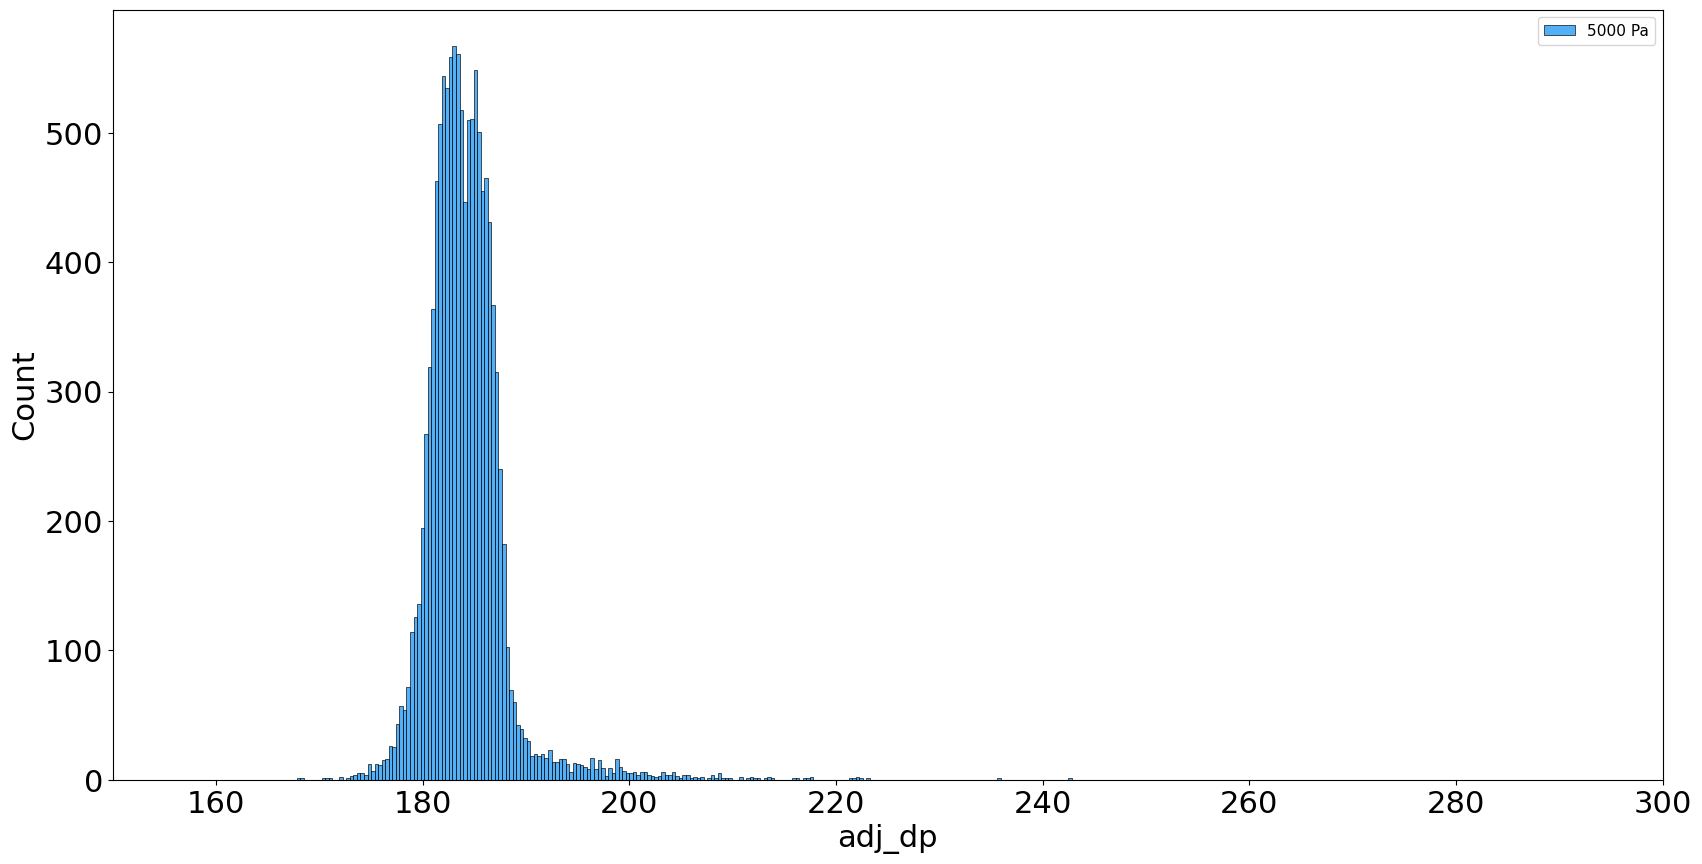

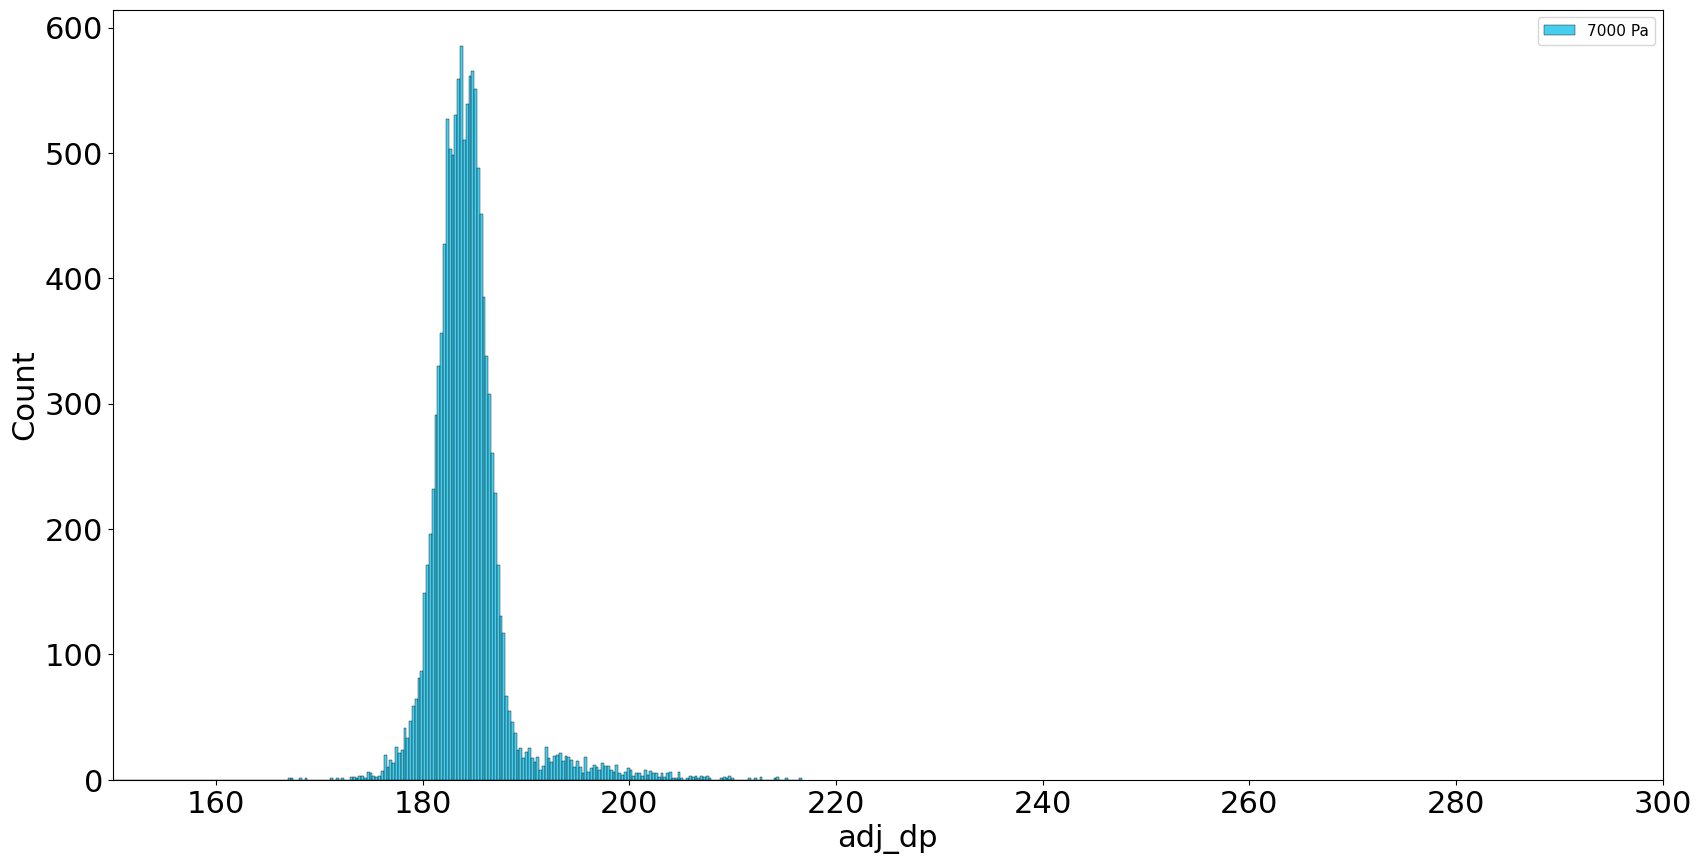

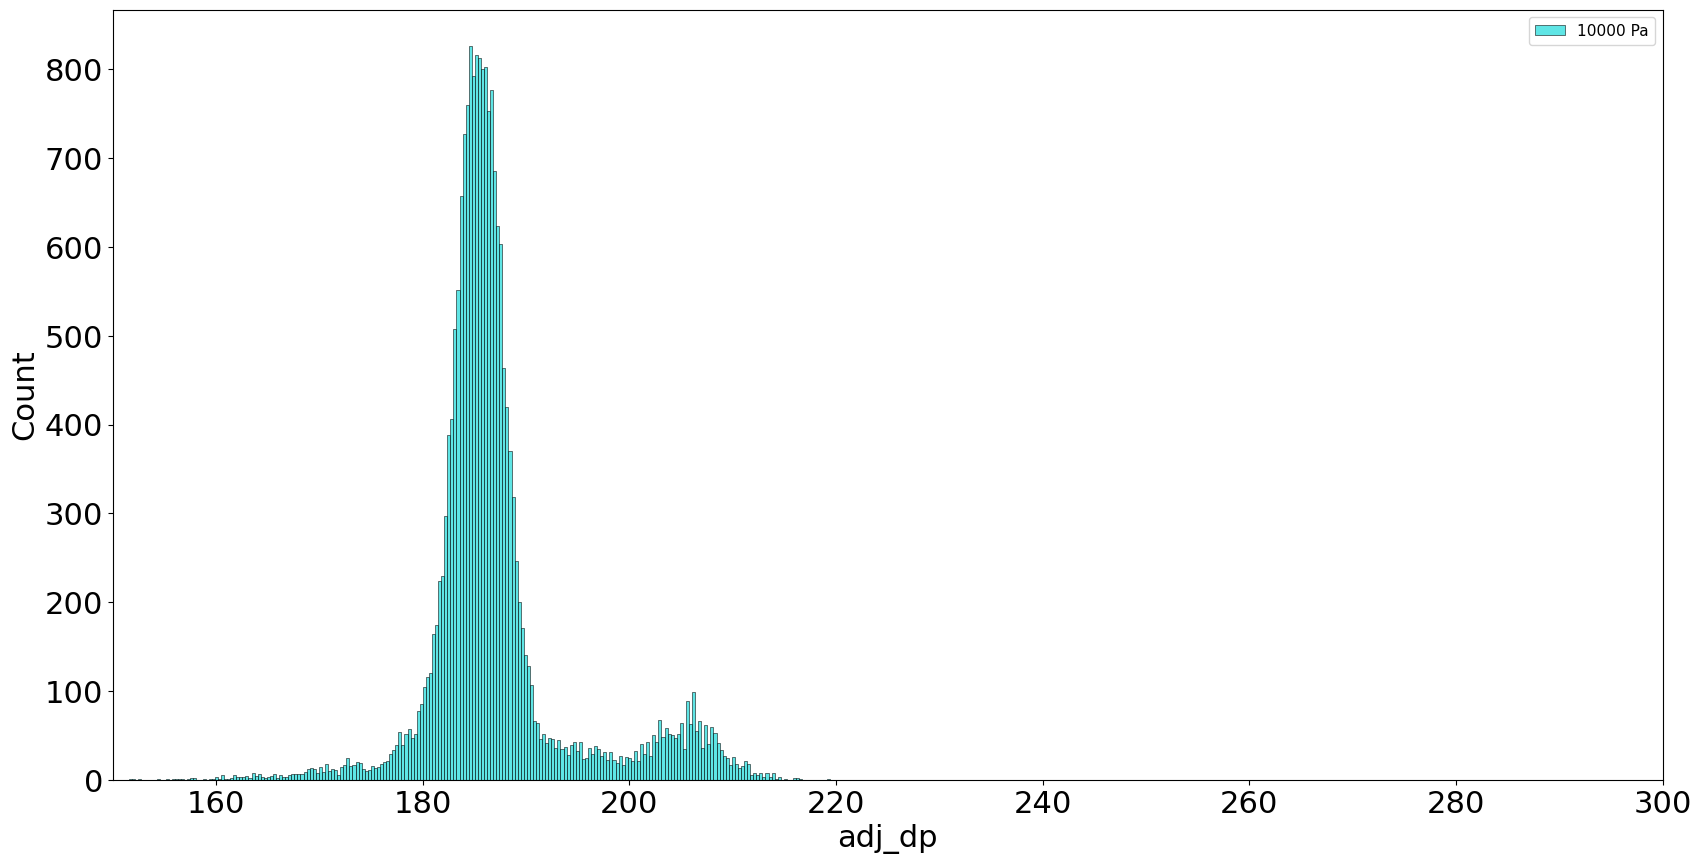

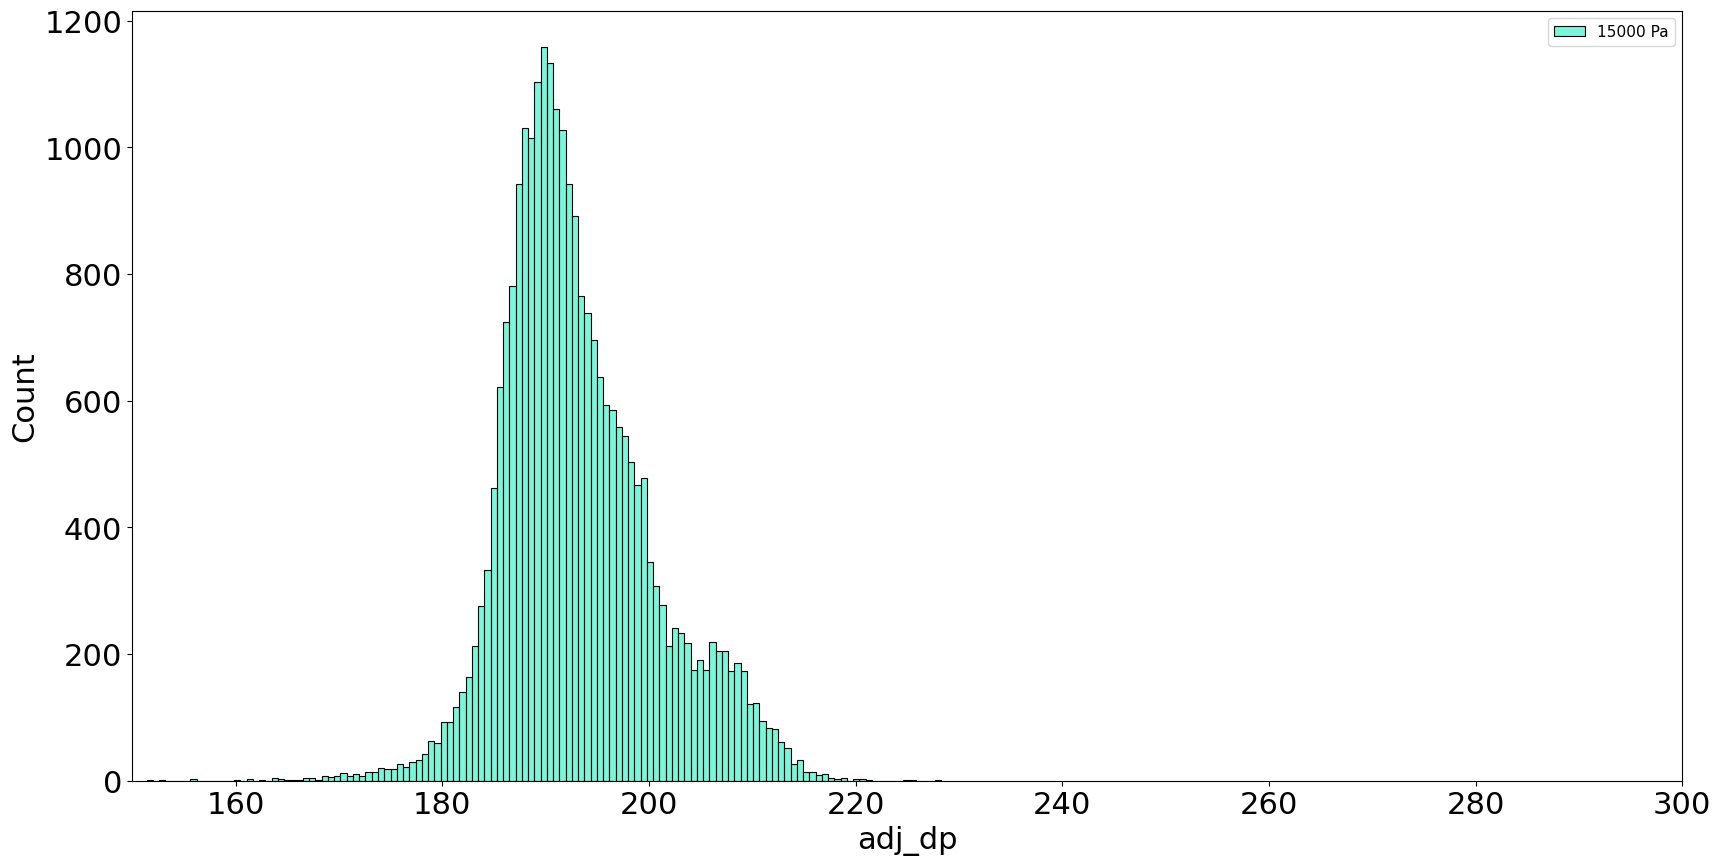

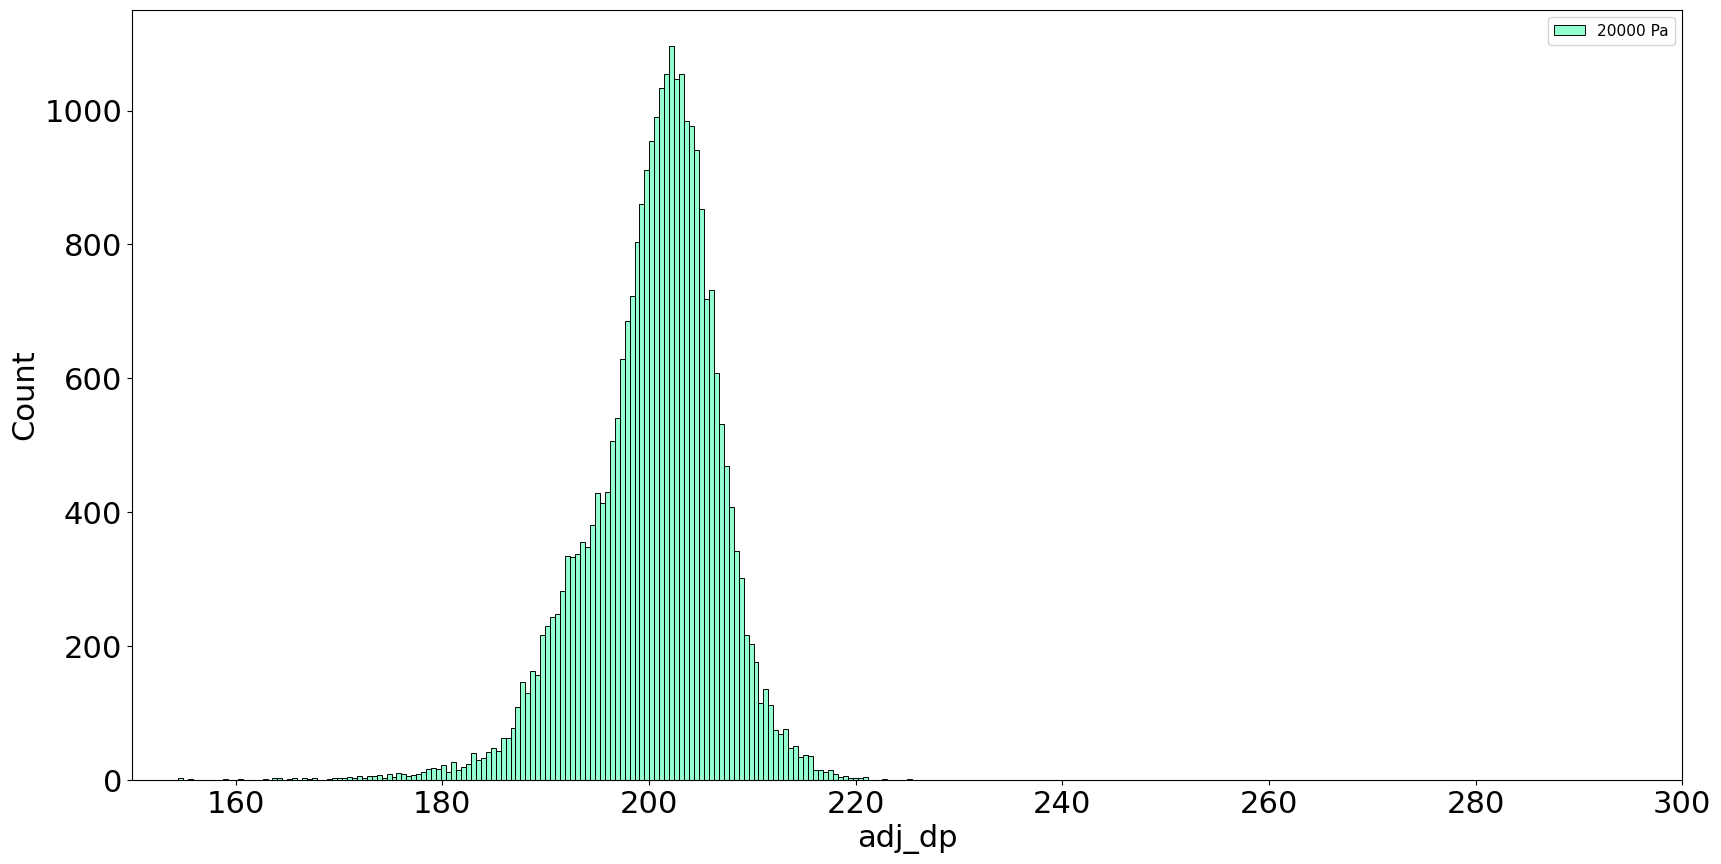

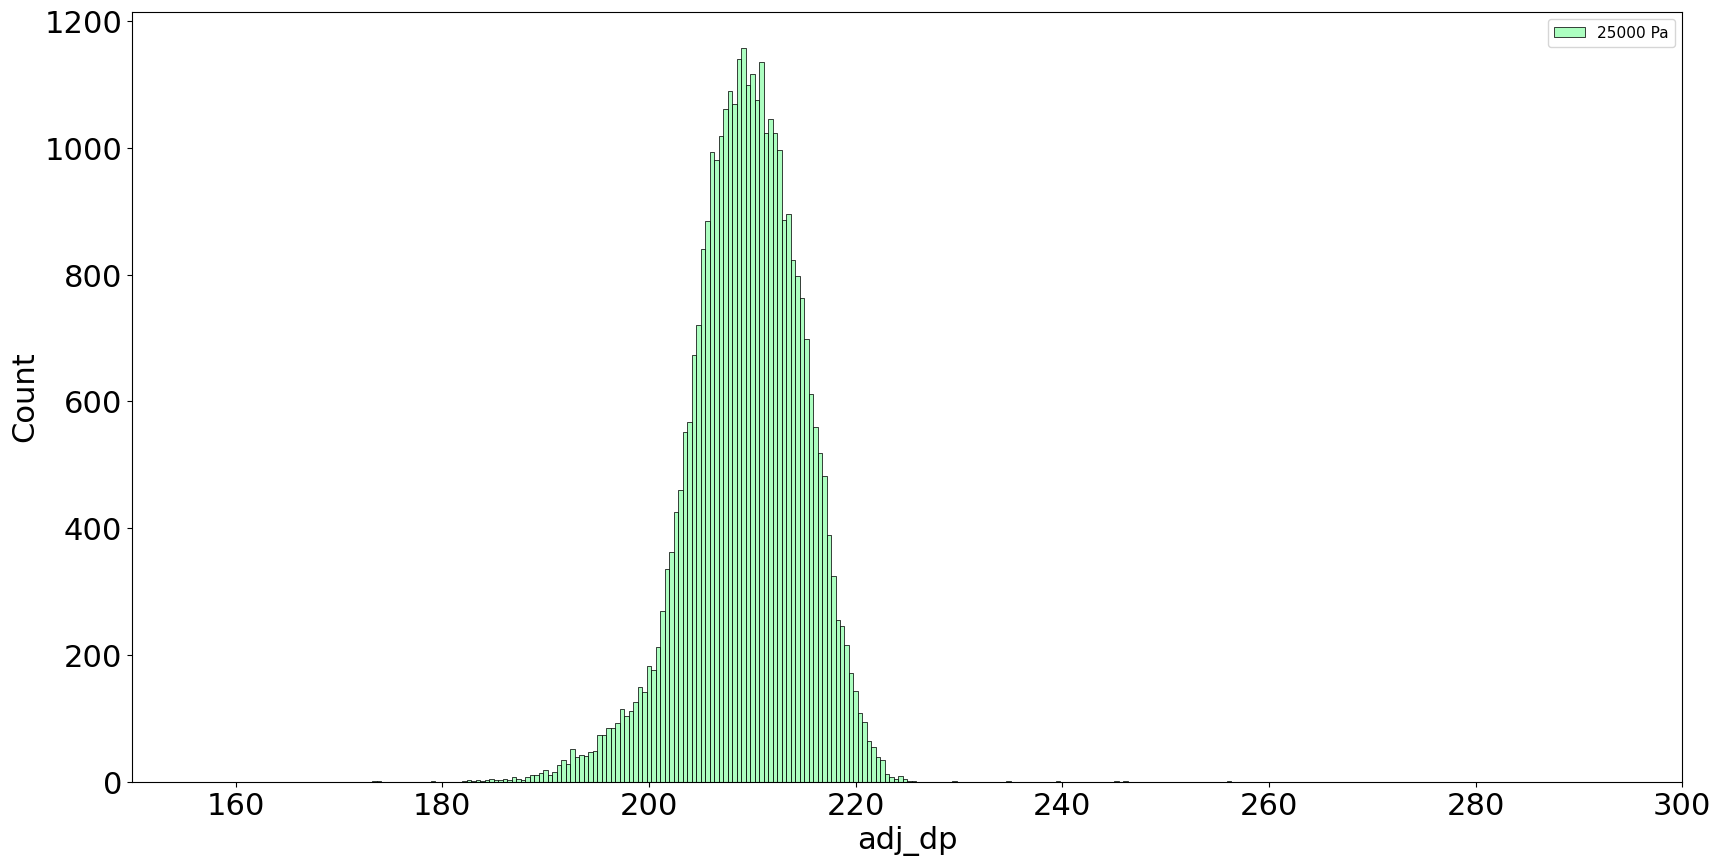

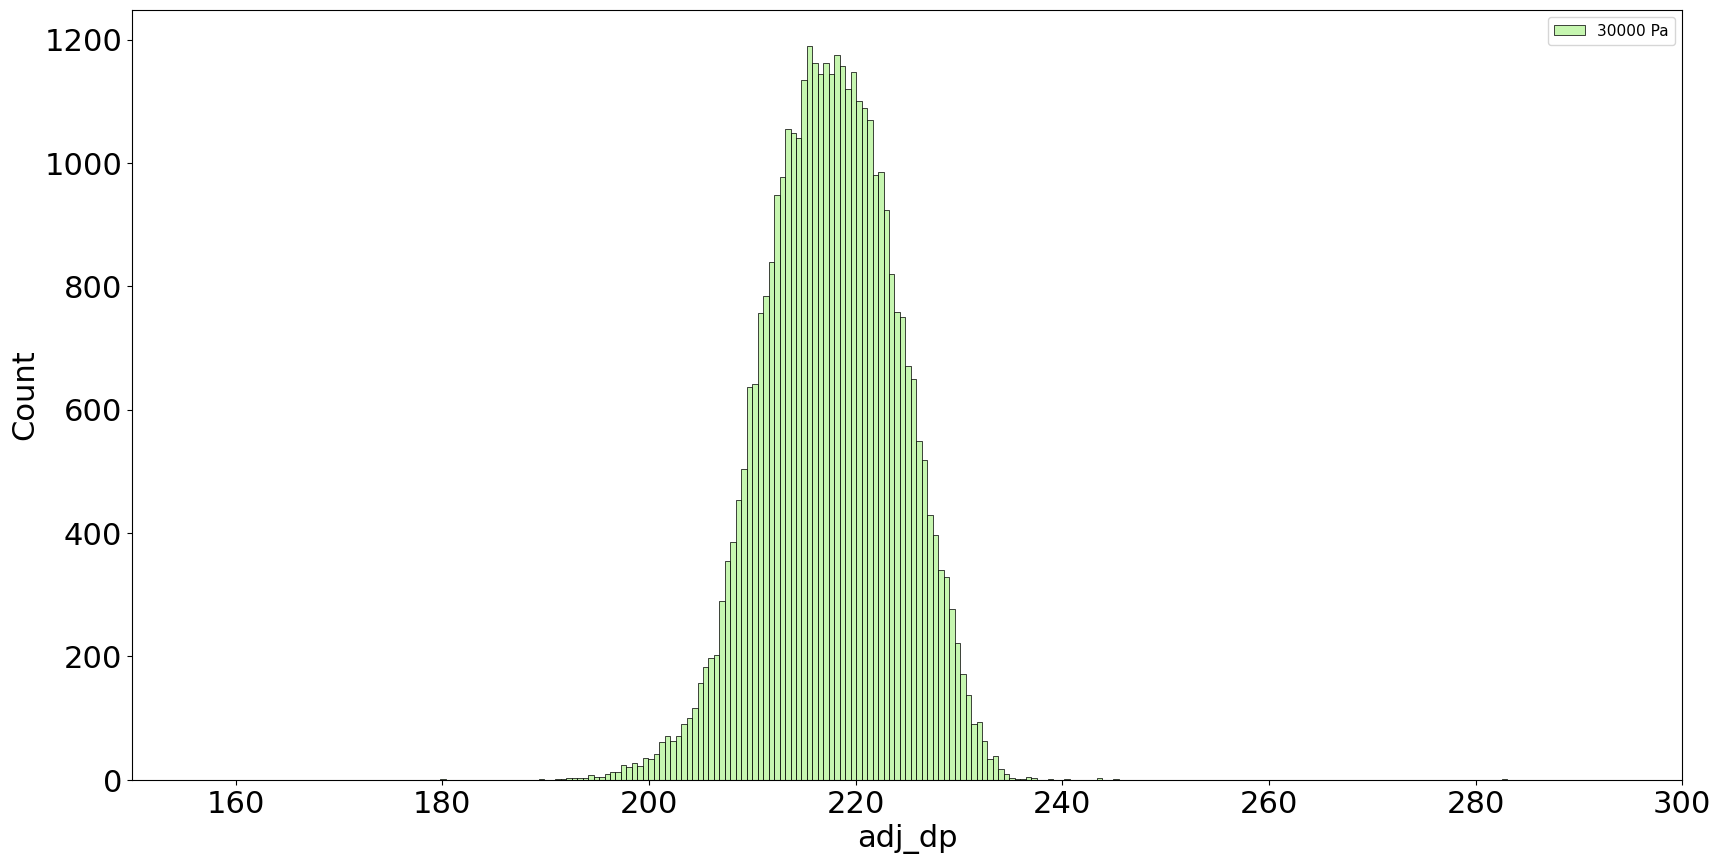

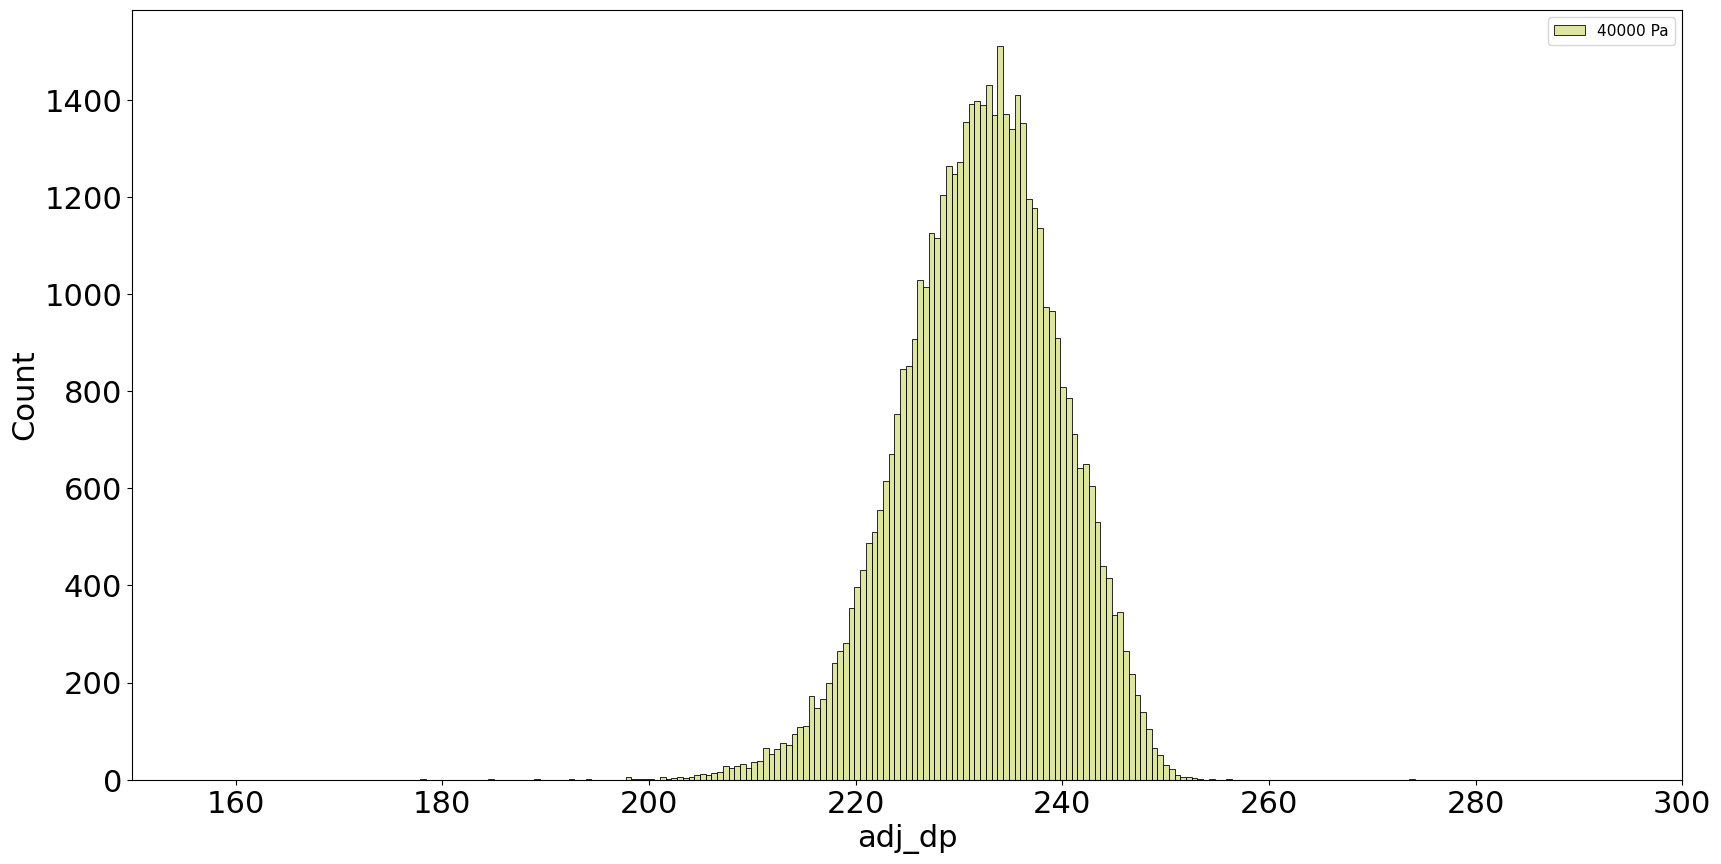

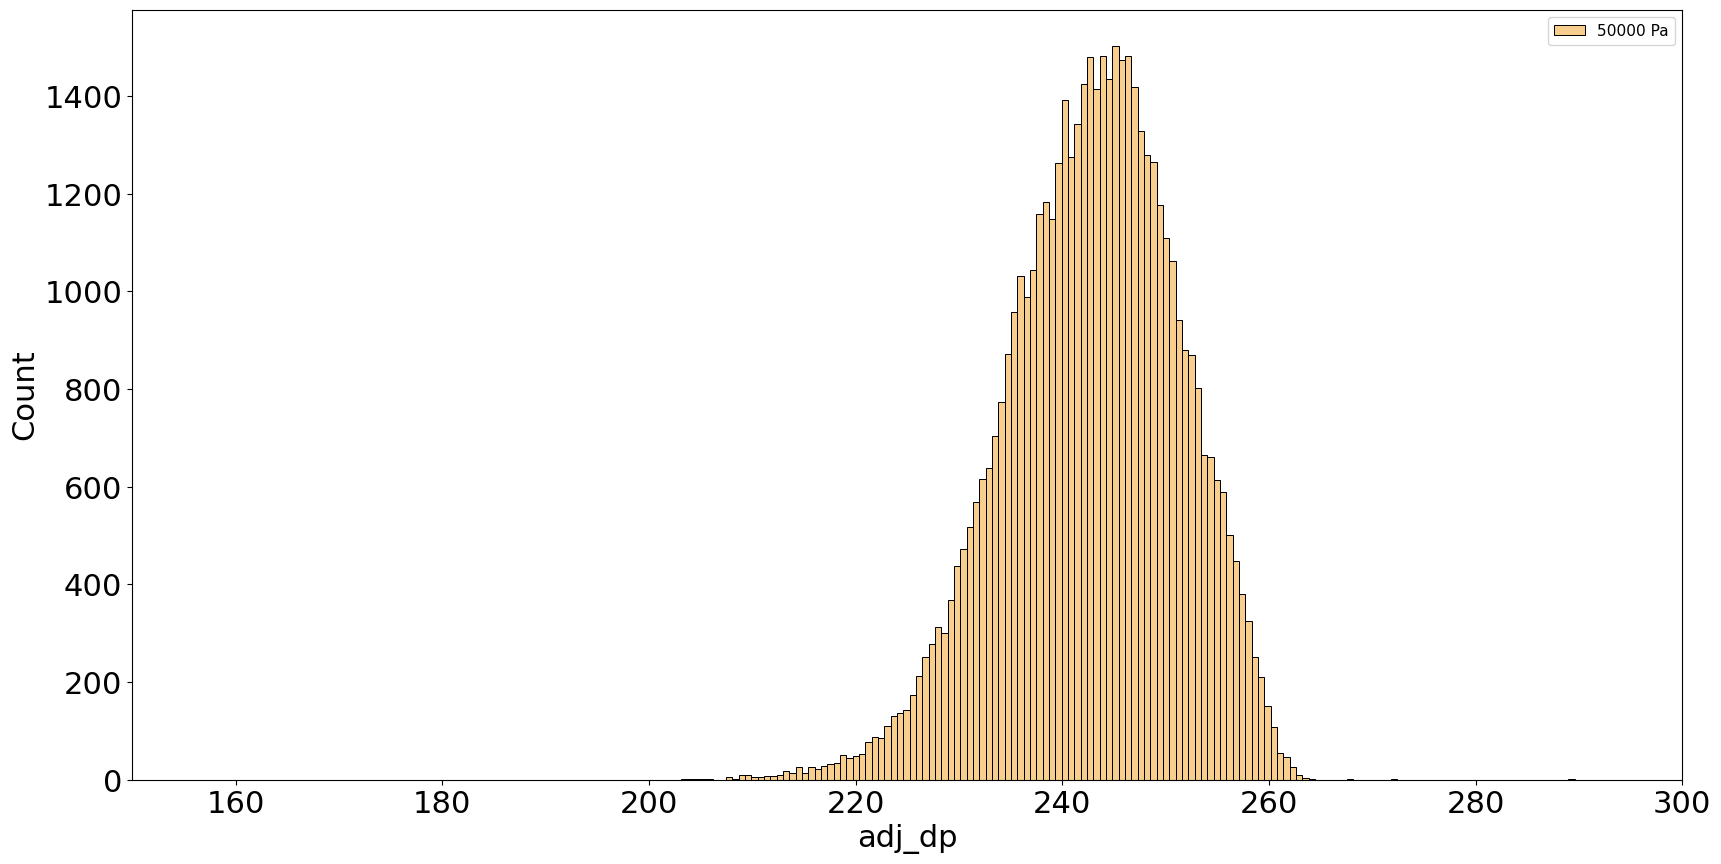

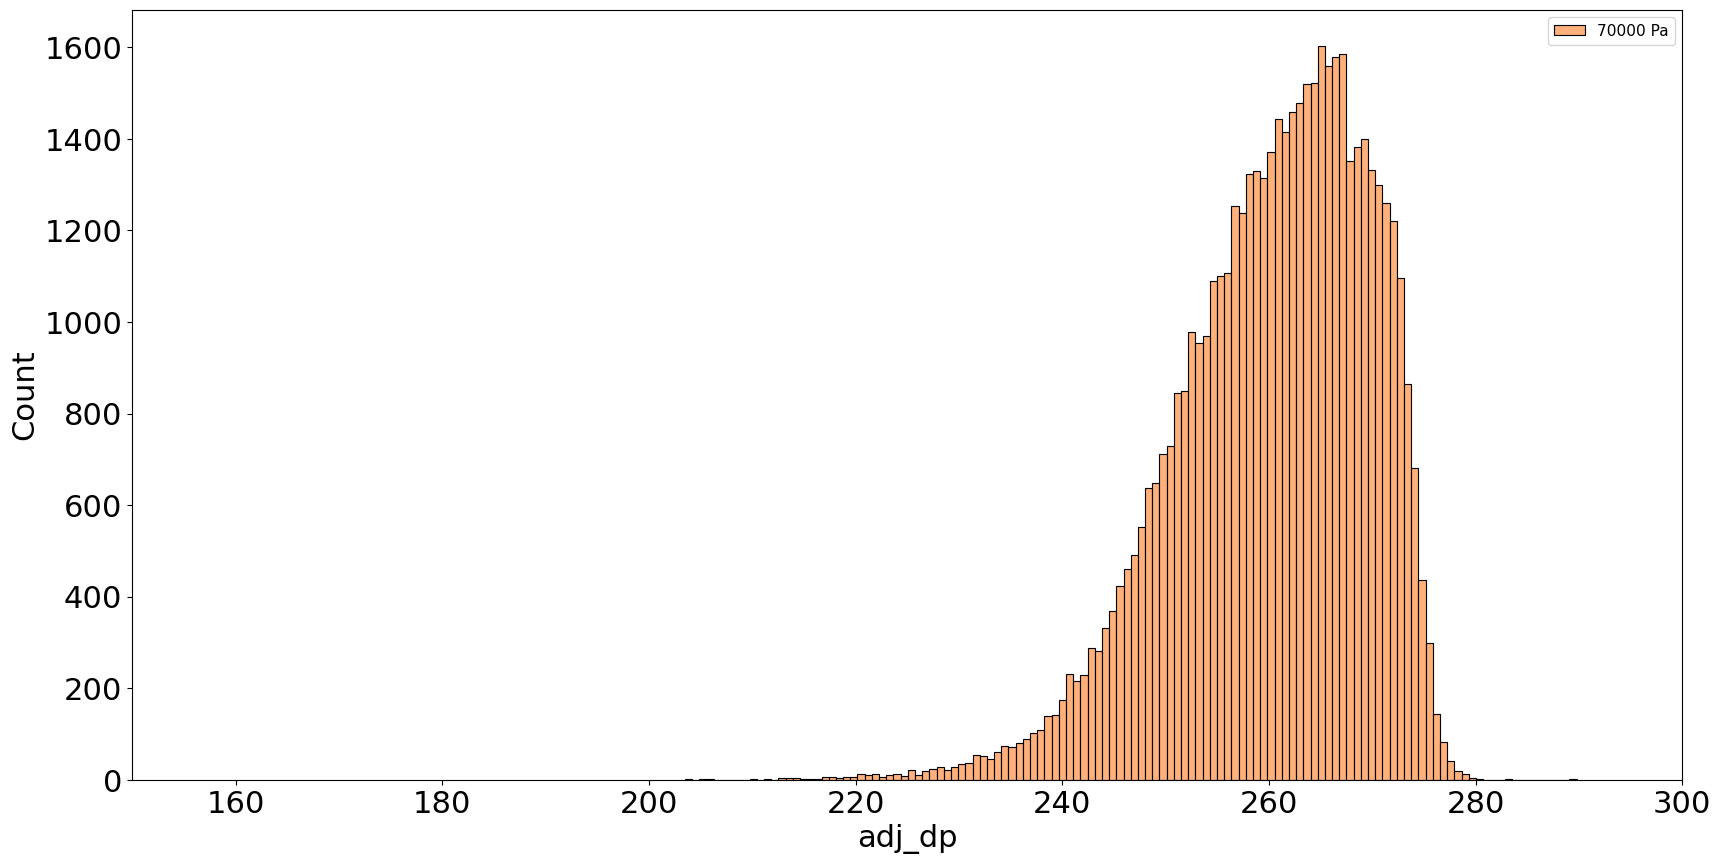

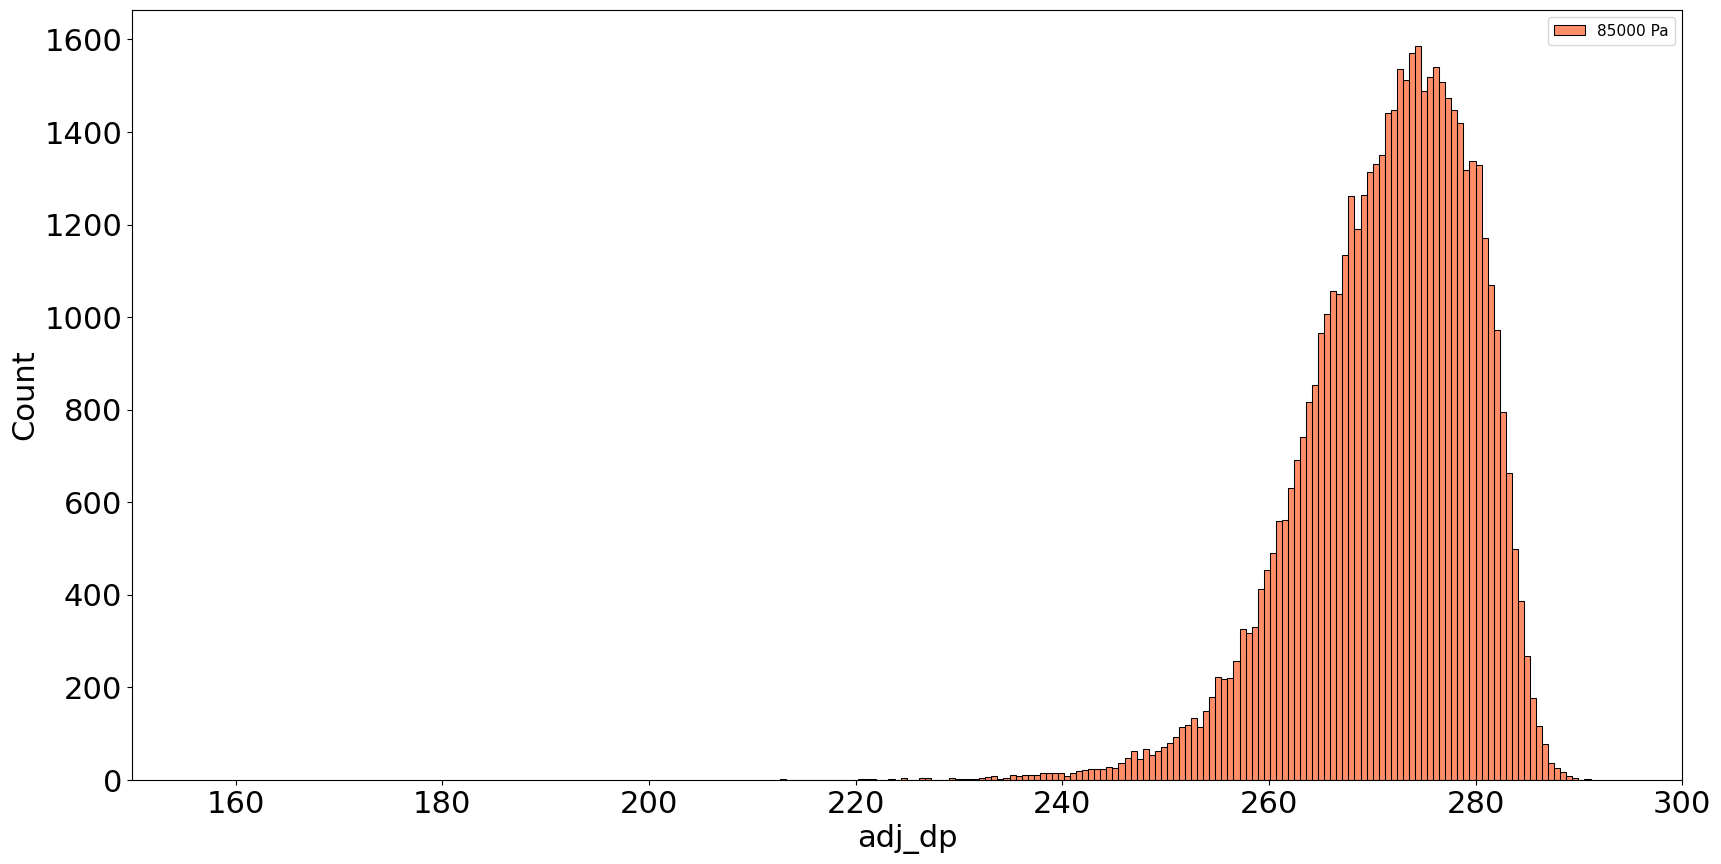

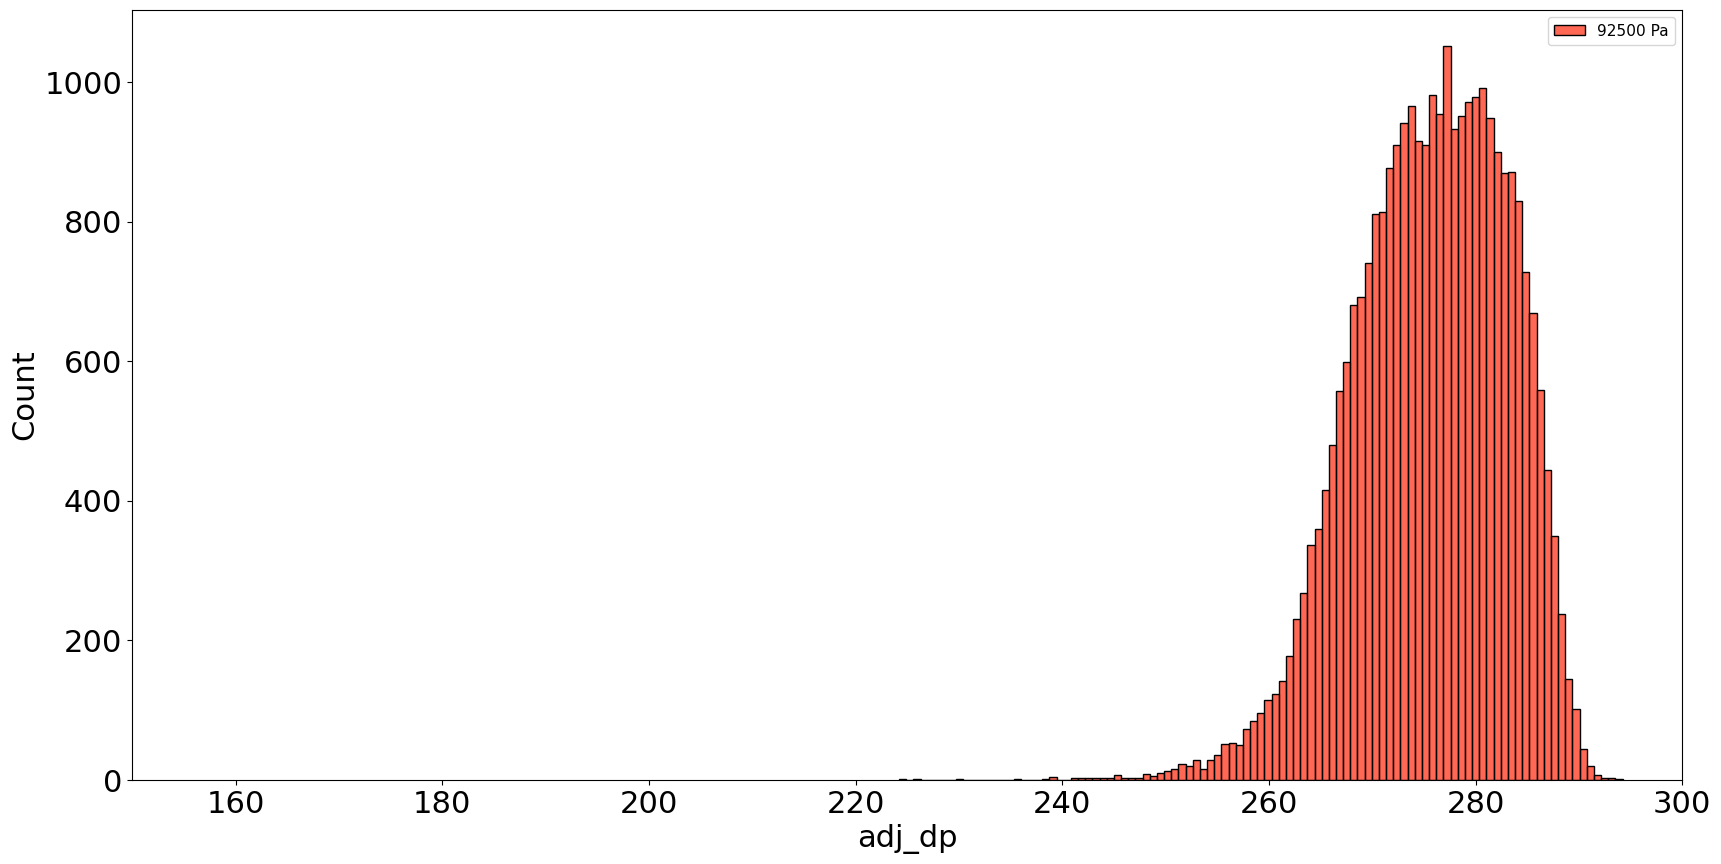

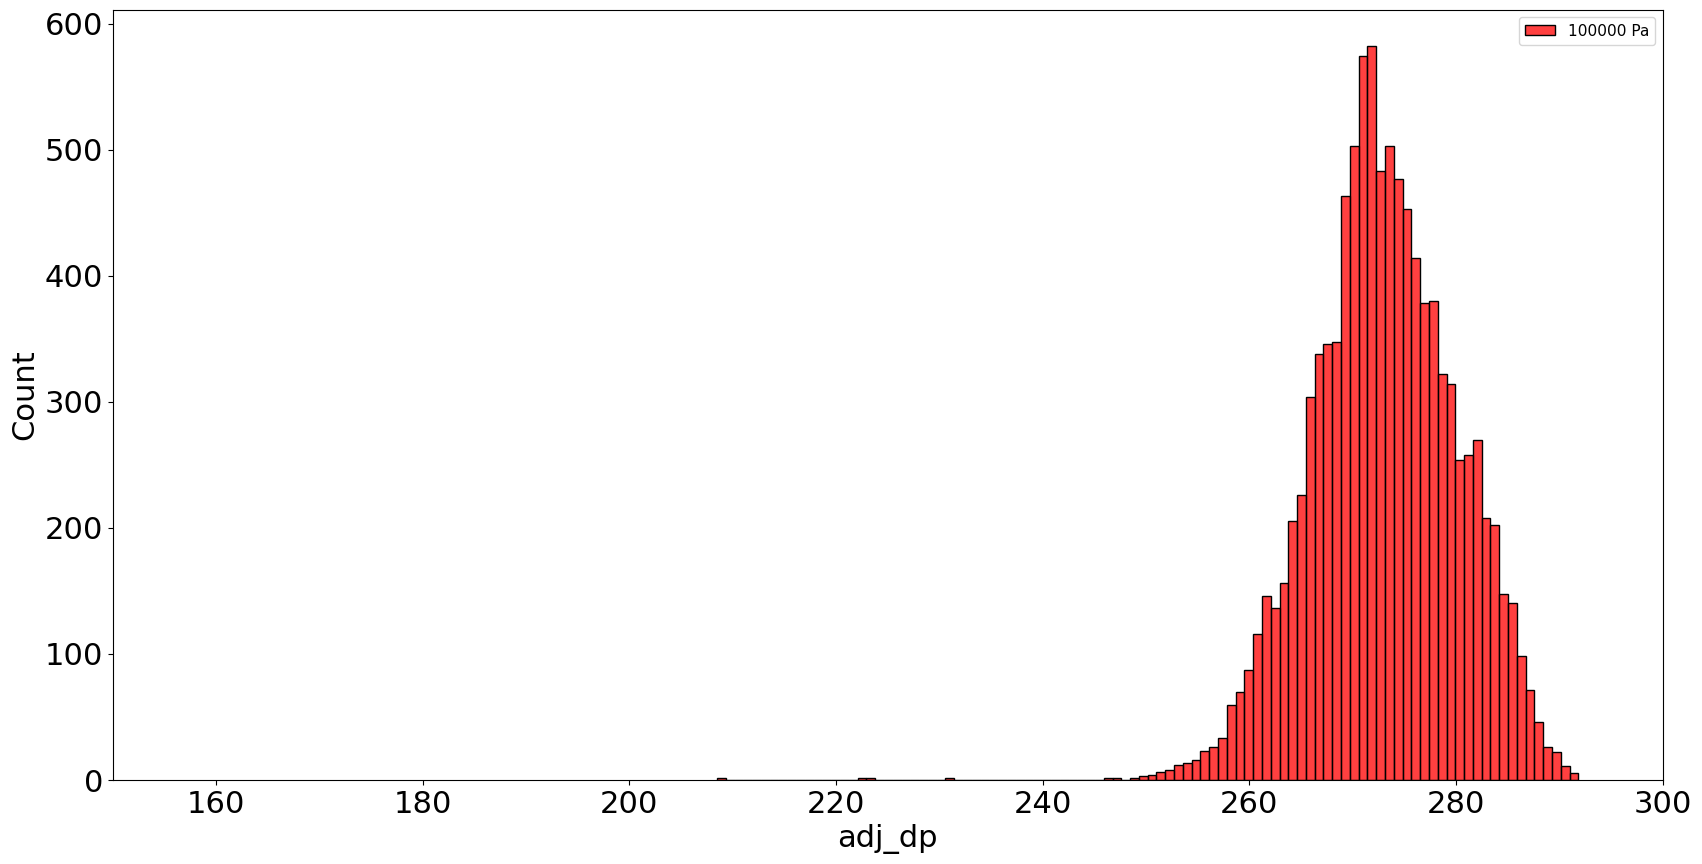

In [12]:
for i in plevs:
    seaborn.histplot(data=df_final[df_final.z_coordinate == i], x="adj_dp", color=plev_color[i], label = str(i) + ' Pa', legend=False)
font = font_manager.FontProperties(size=11)
plt.legend(prop=font)
plt.xlim(150, 300)
plt.show()
plt.close()

for i in plevs:
    seaborn.histplot(data=df_final[df_final.z_coordinate == i], x="adj_dp", color=plev_color[i], label = str(i) + ' Pa', legend=False)
    font = font_manager.FontProperties(size=11)
    plt.legend(prop=font)
    plt.xlim(150, 300)
    plt.show()
    plt.close()    

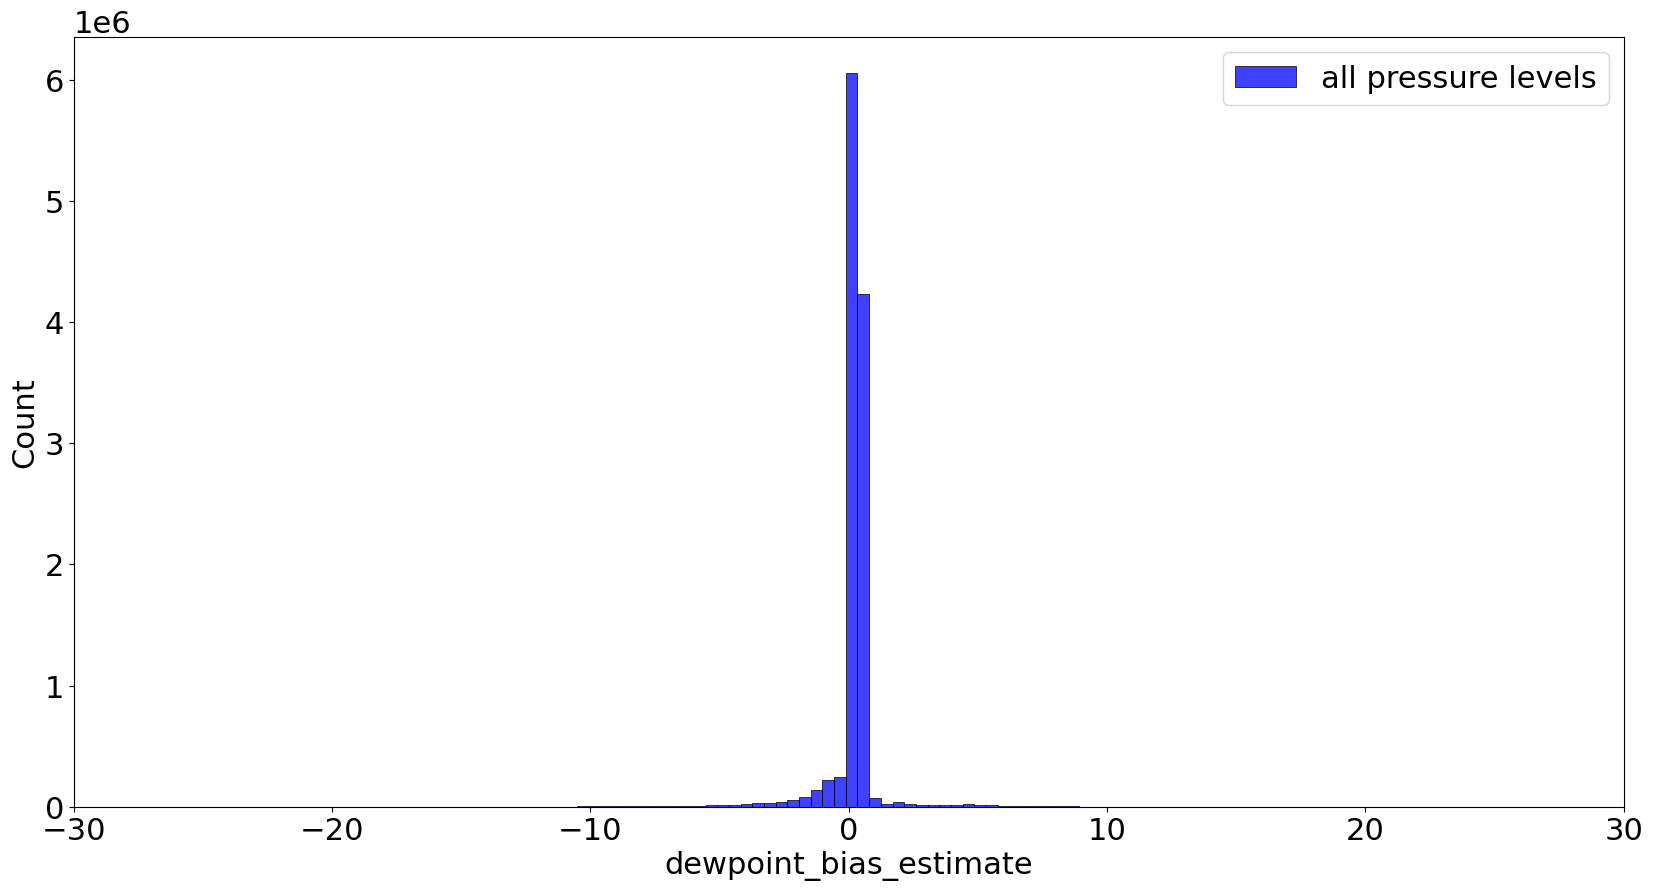

In [44]:
seaborn.histplot(data=df_final, x="dewpoint_bias_estimate", color='blue', bins=200, label='all pressure levels', legend=False)
plt.xlim(-30, 30)
plt.legend()
plt.show()
plt.close()

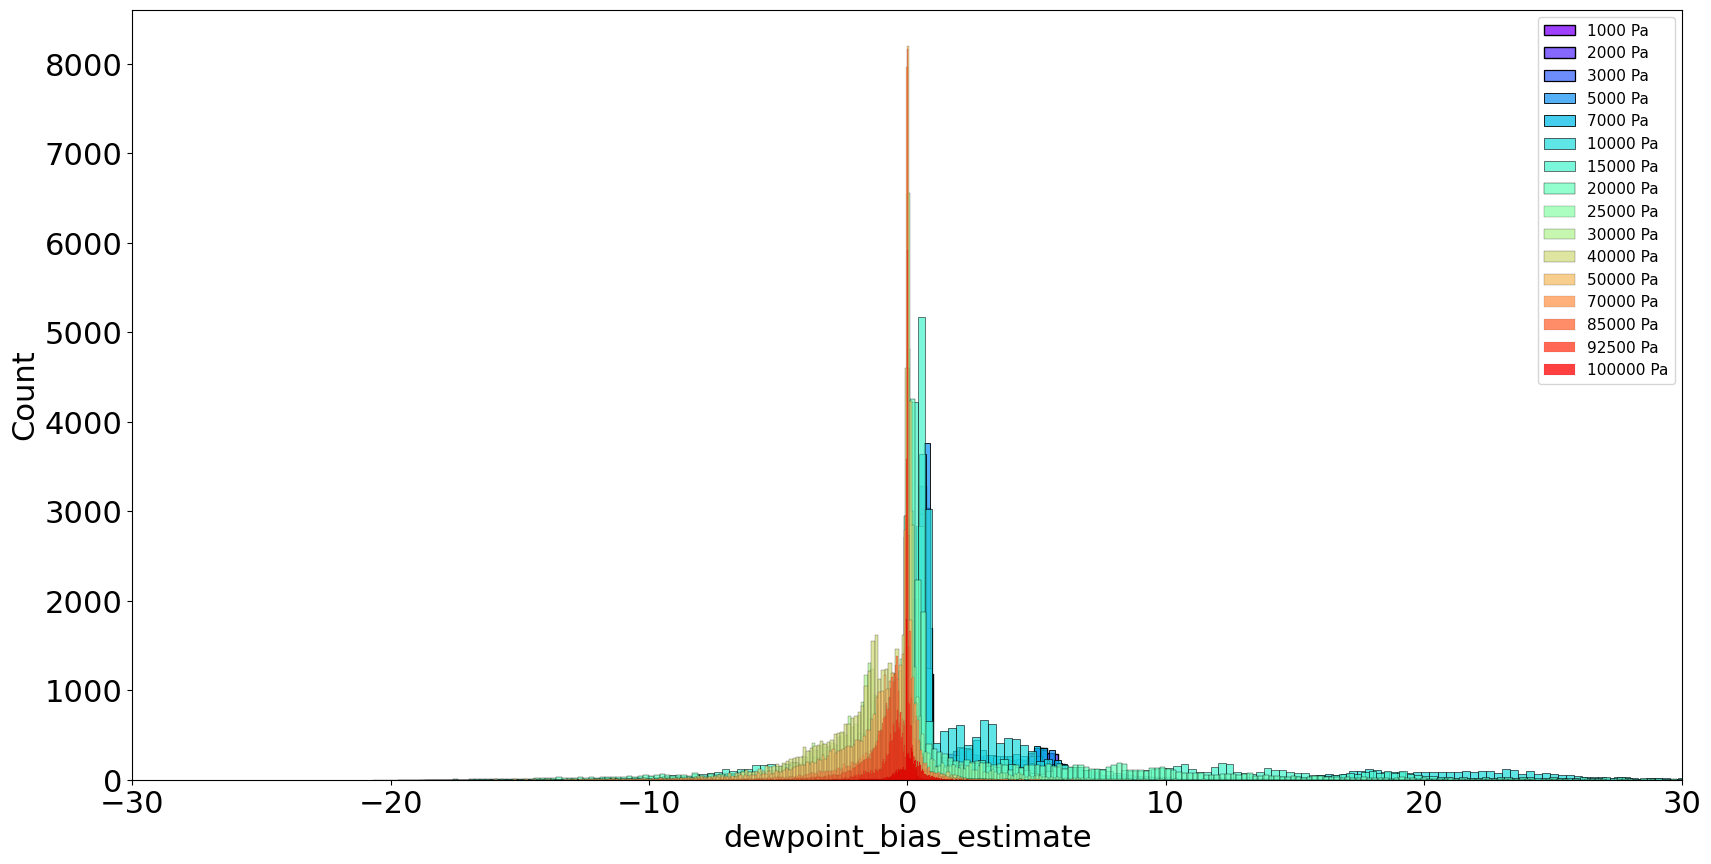

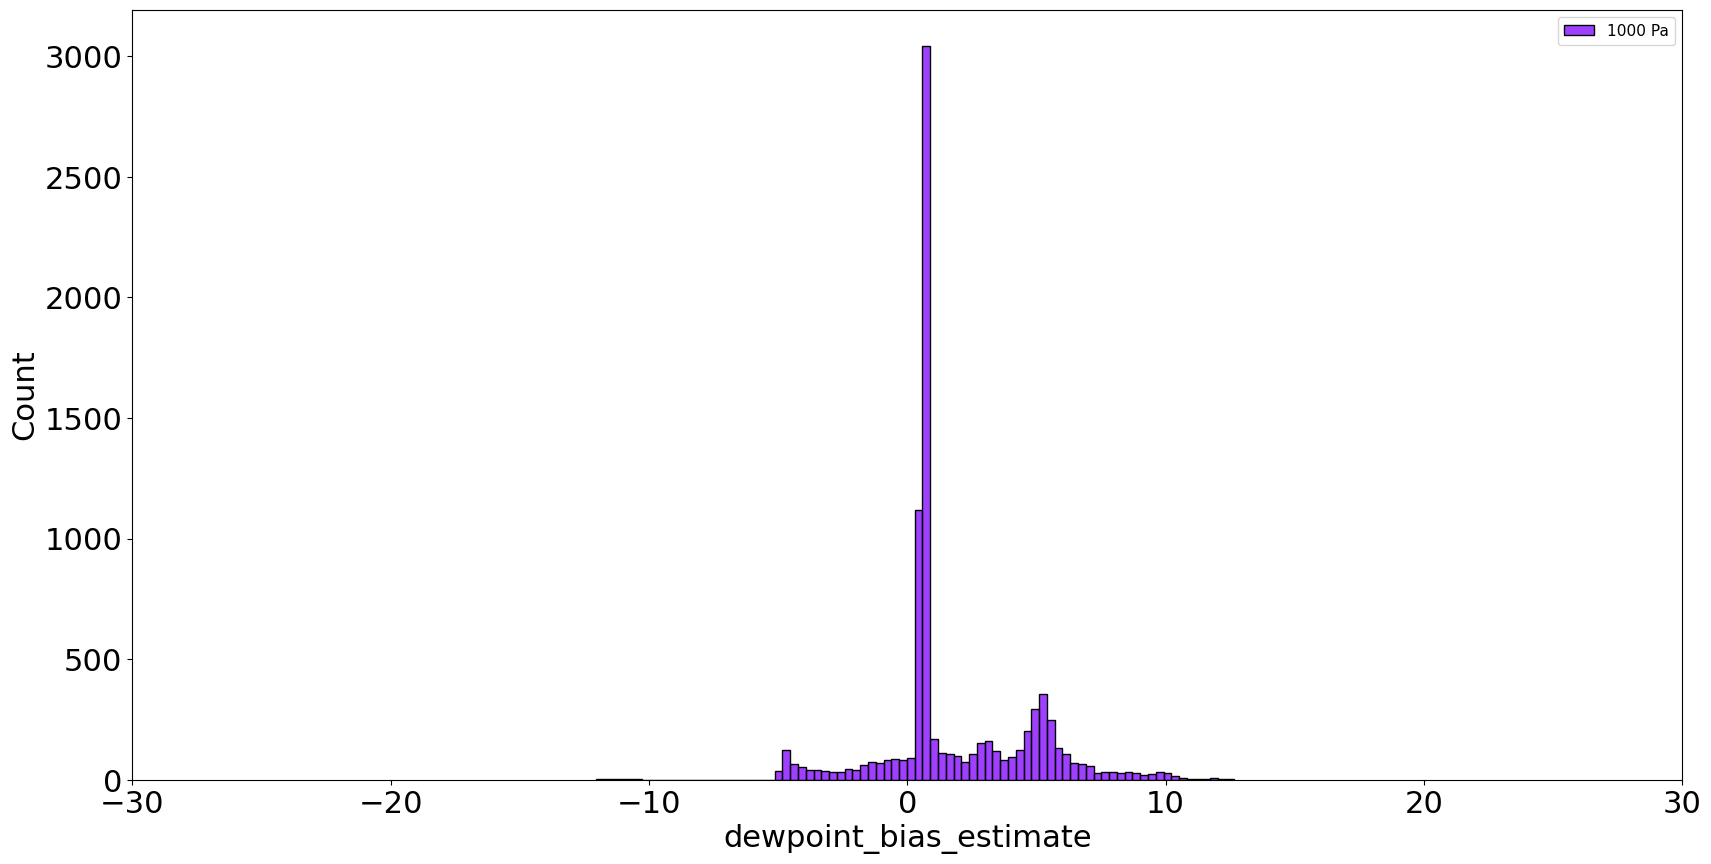

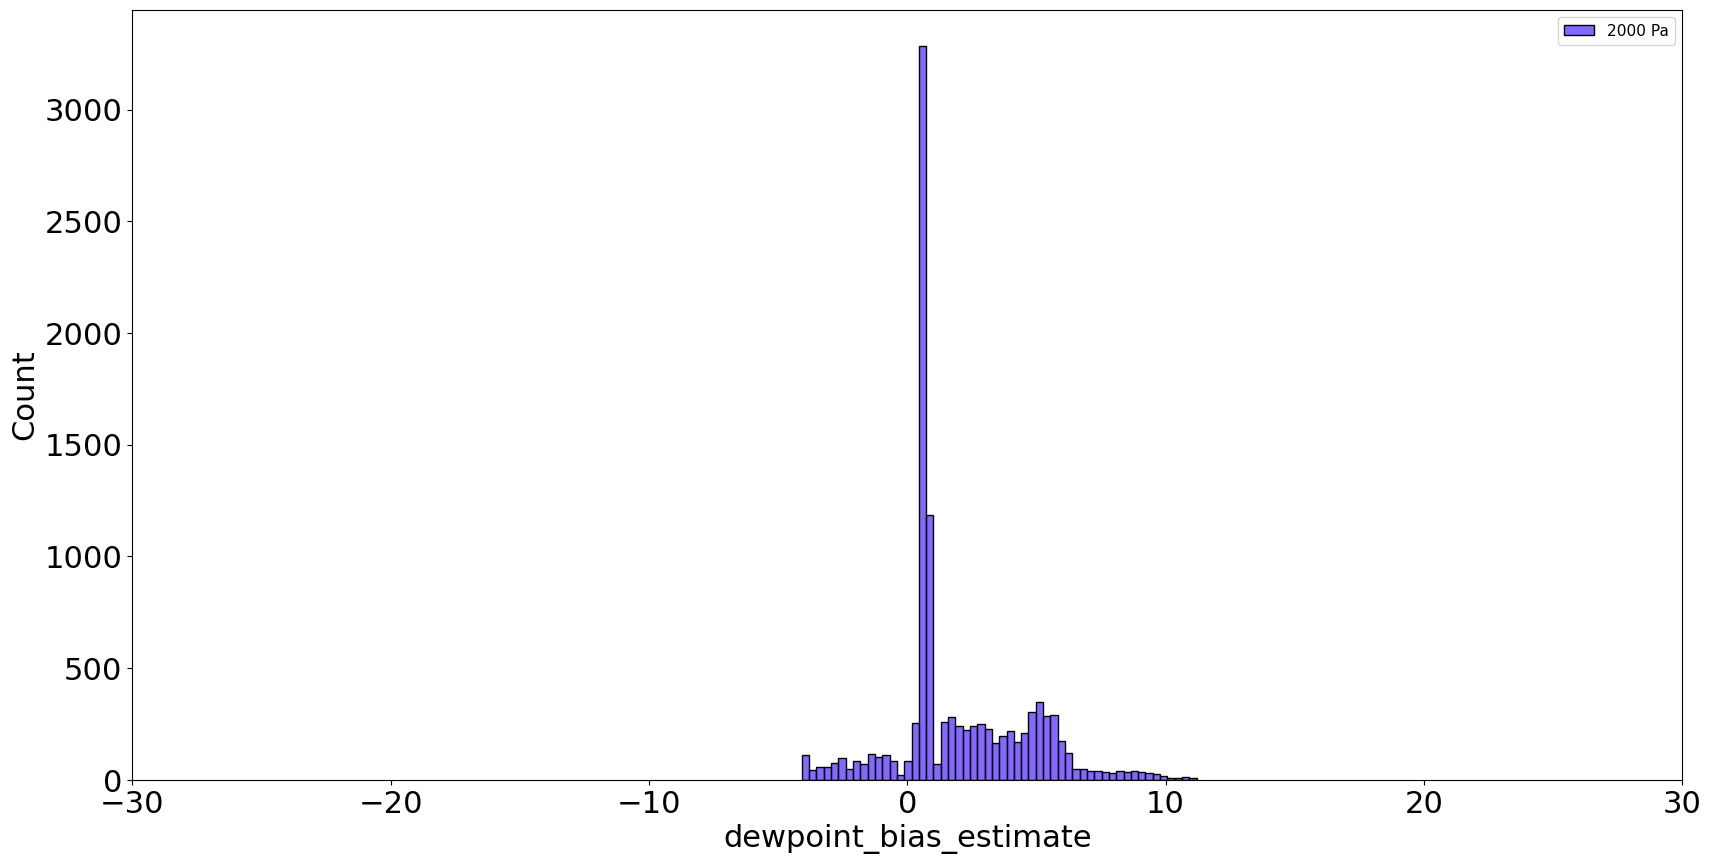

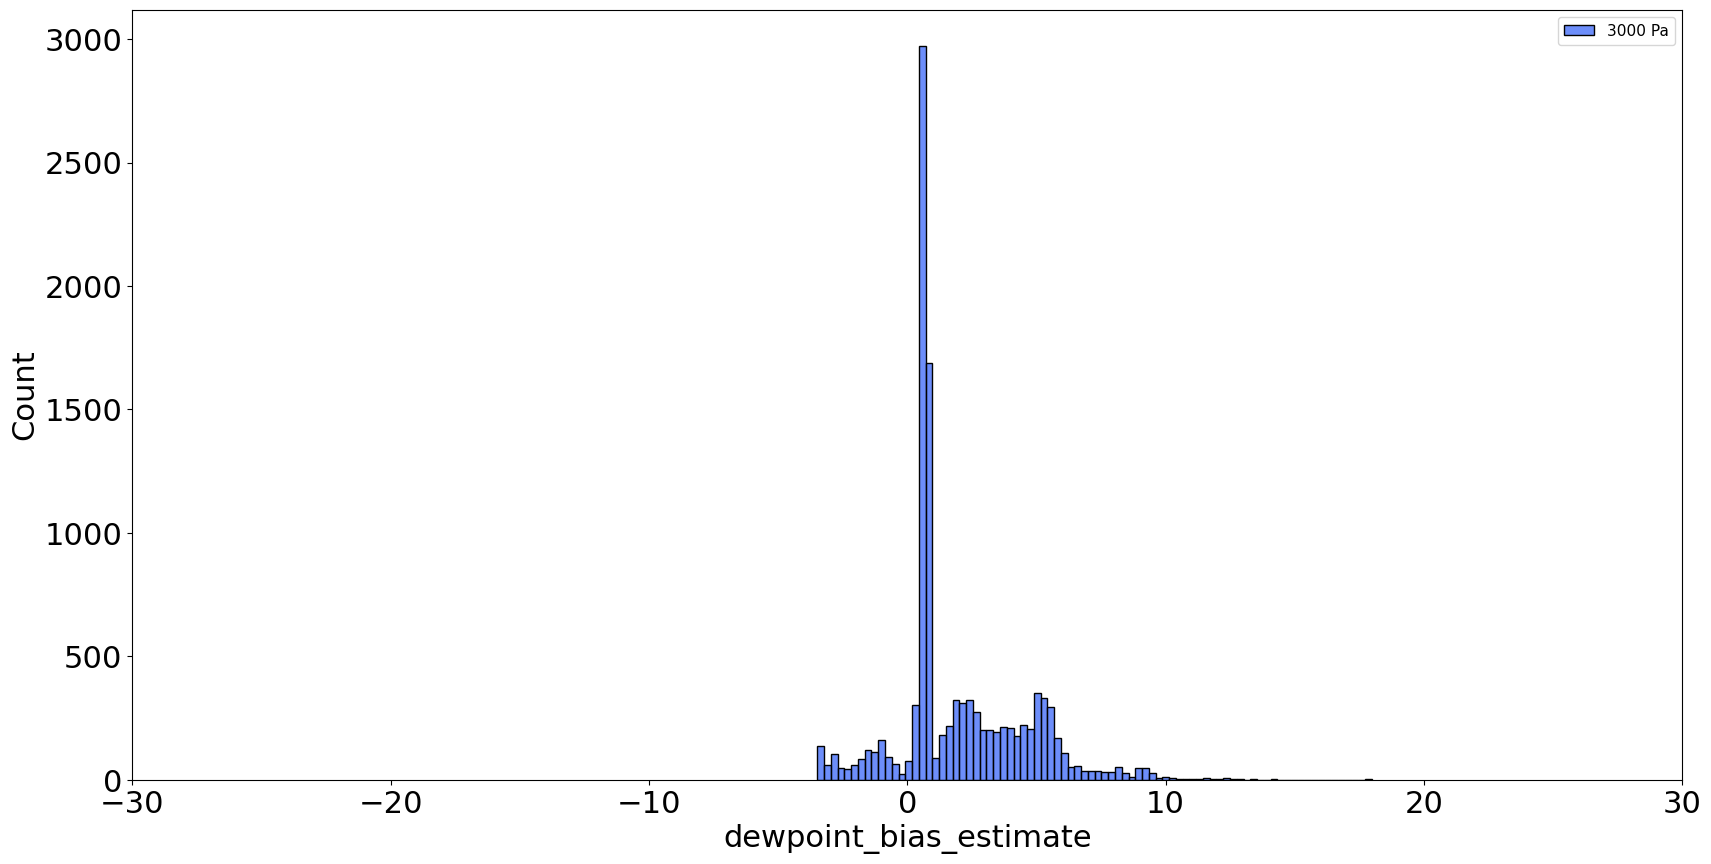

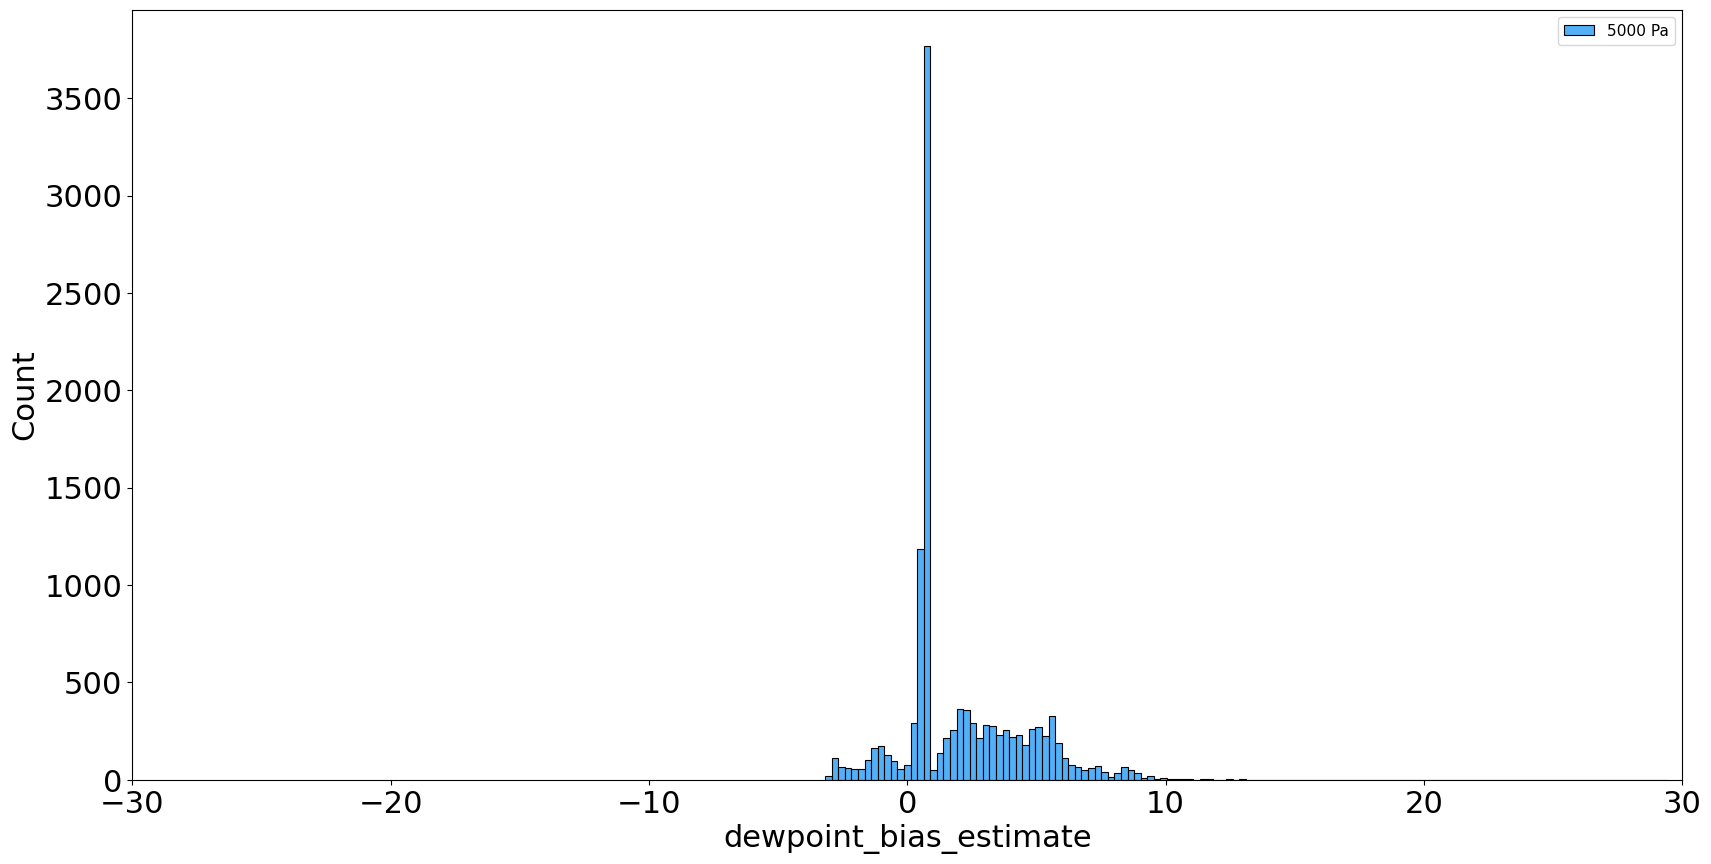

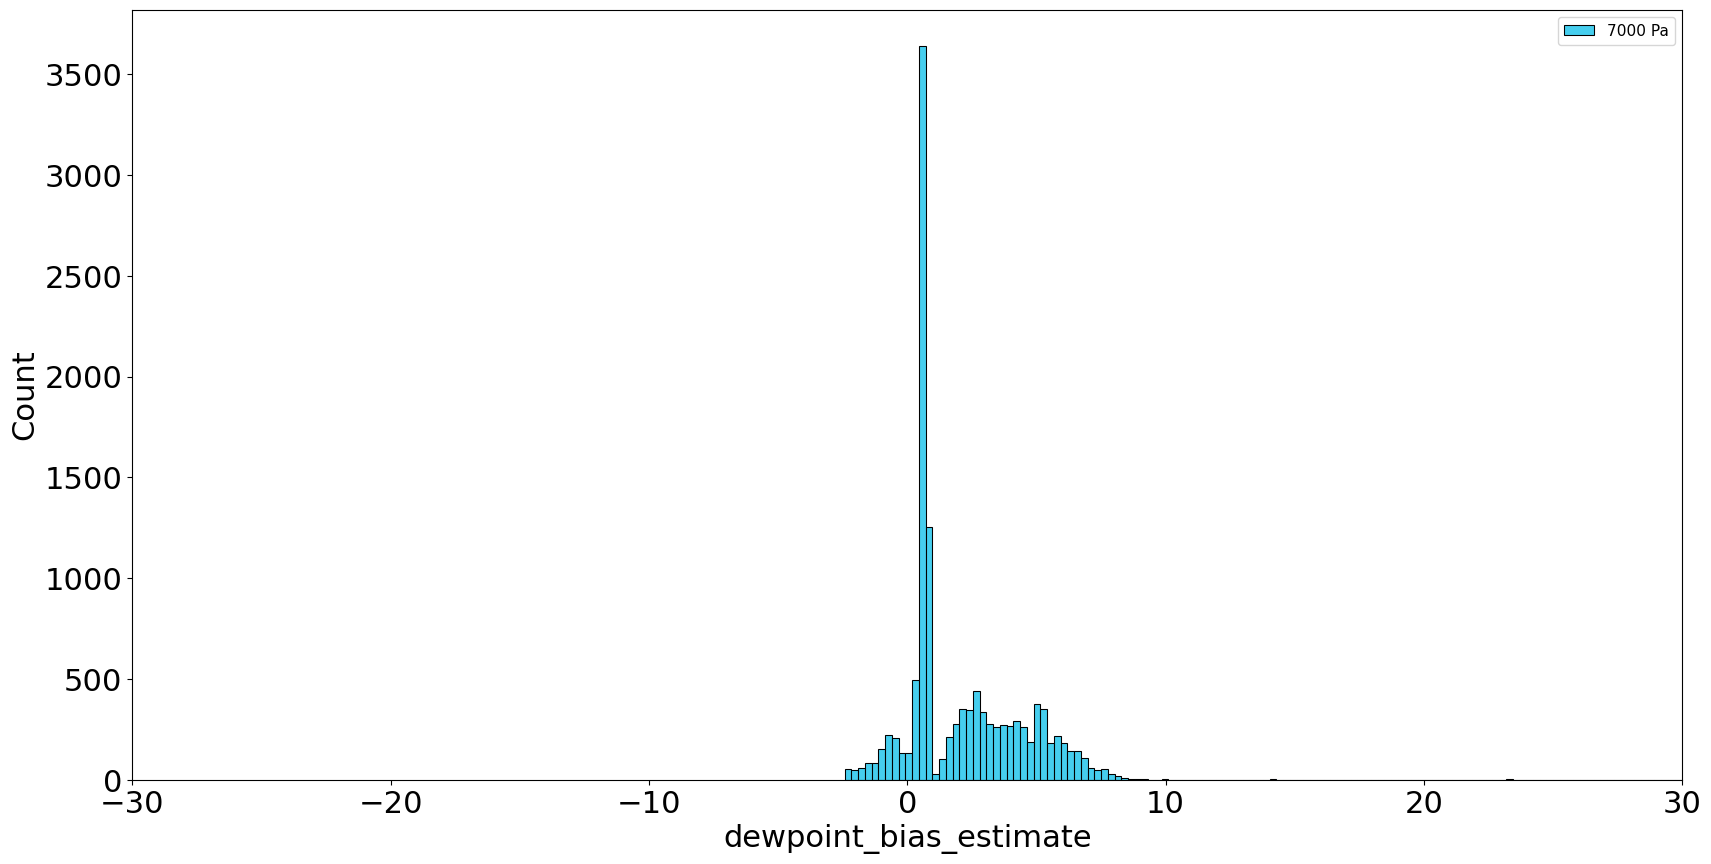

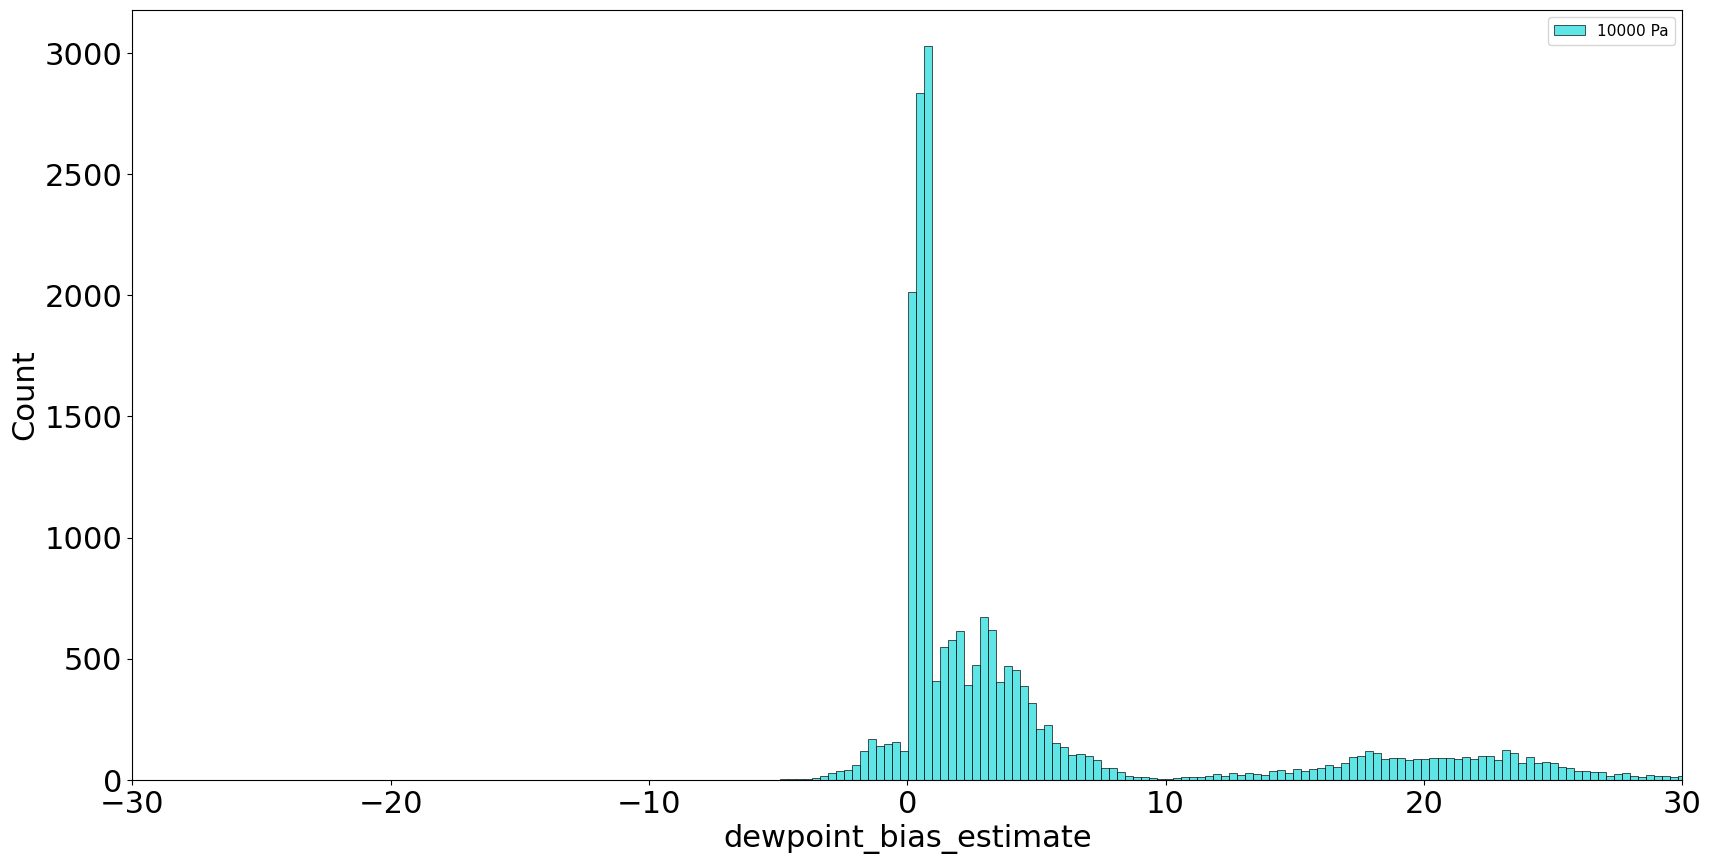

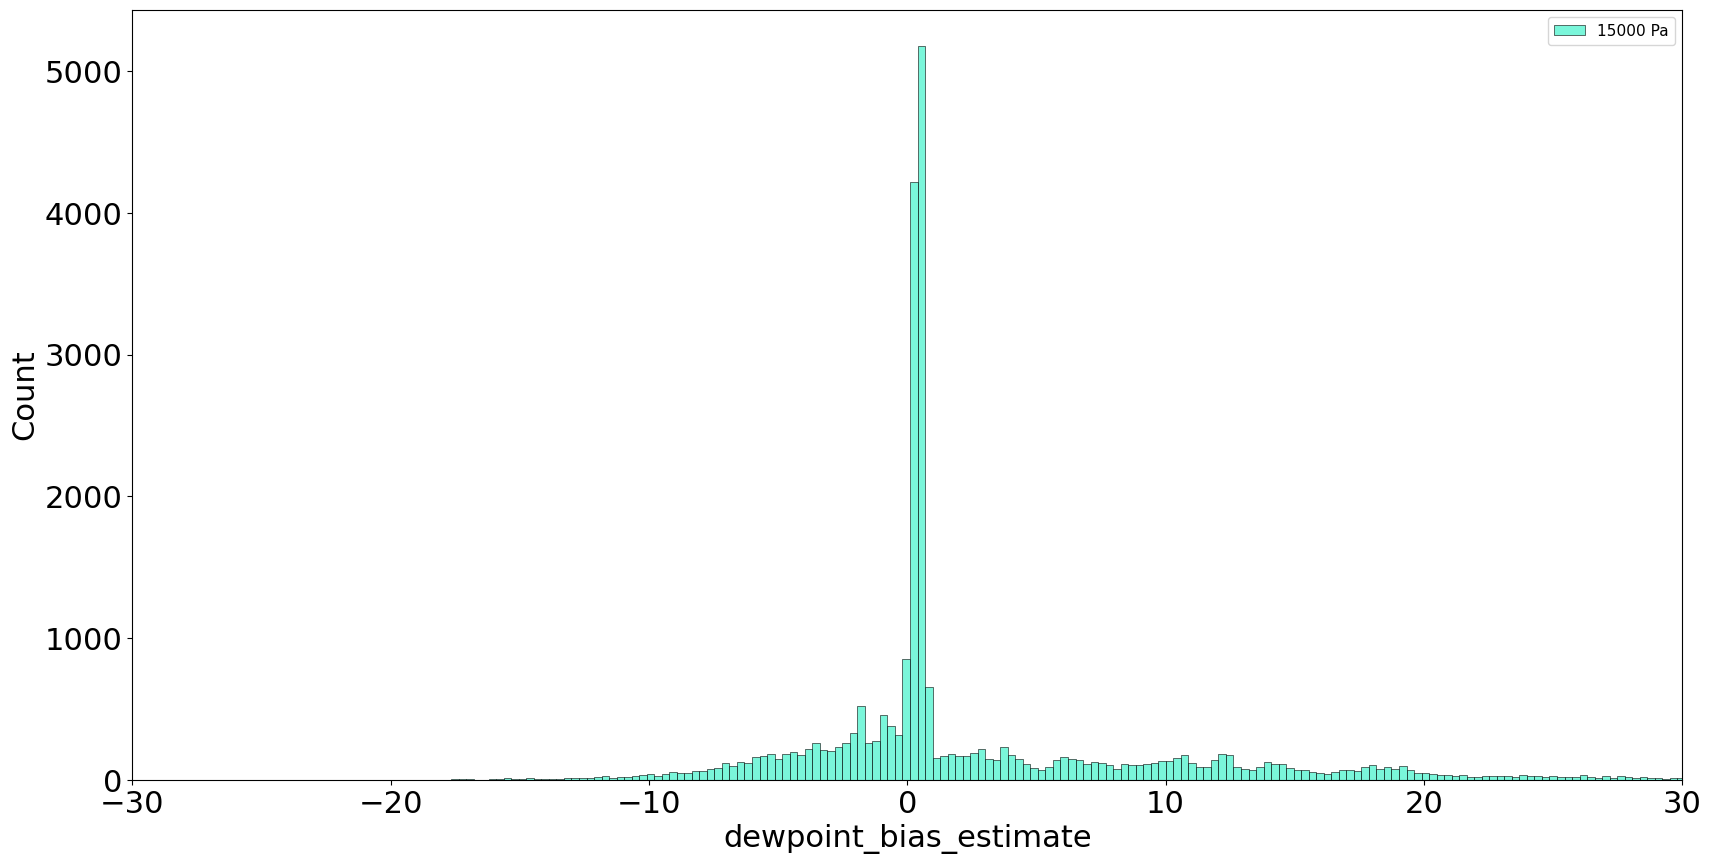

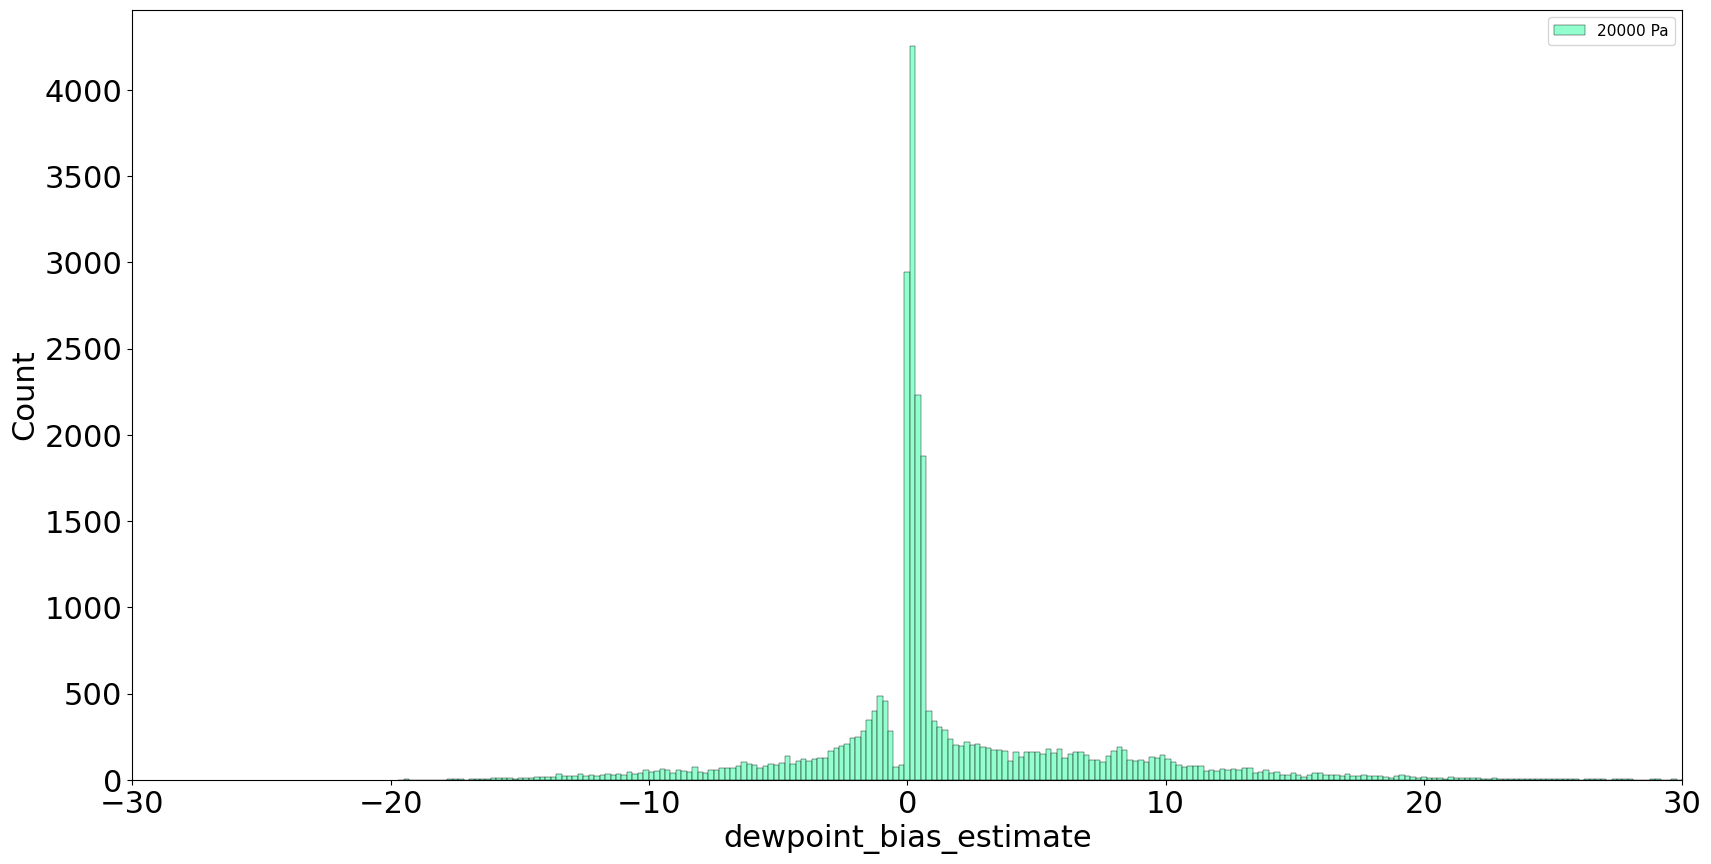

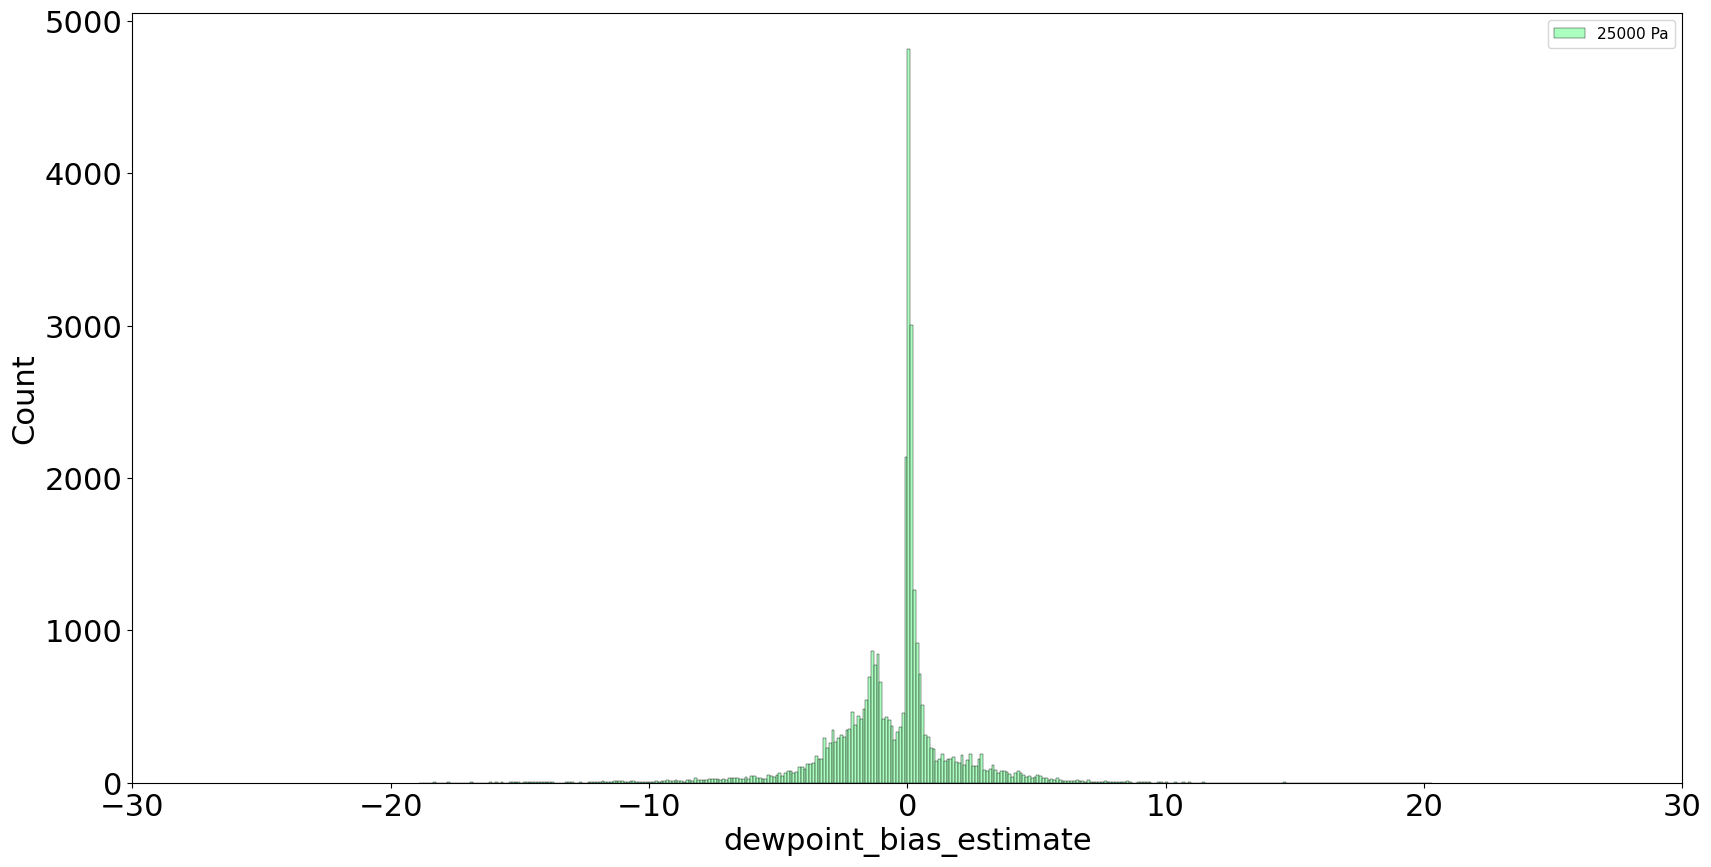

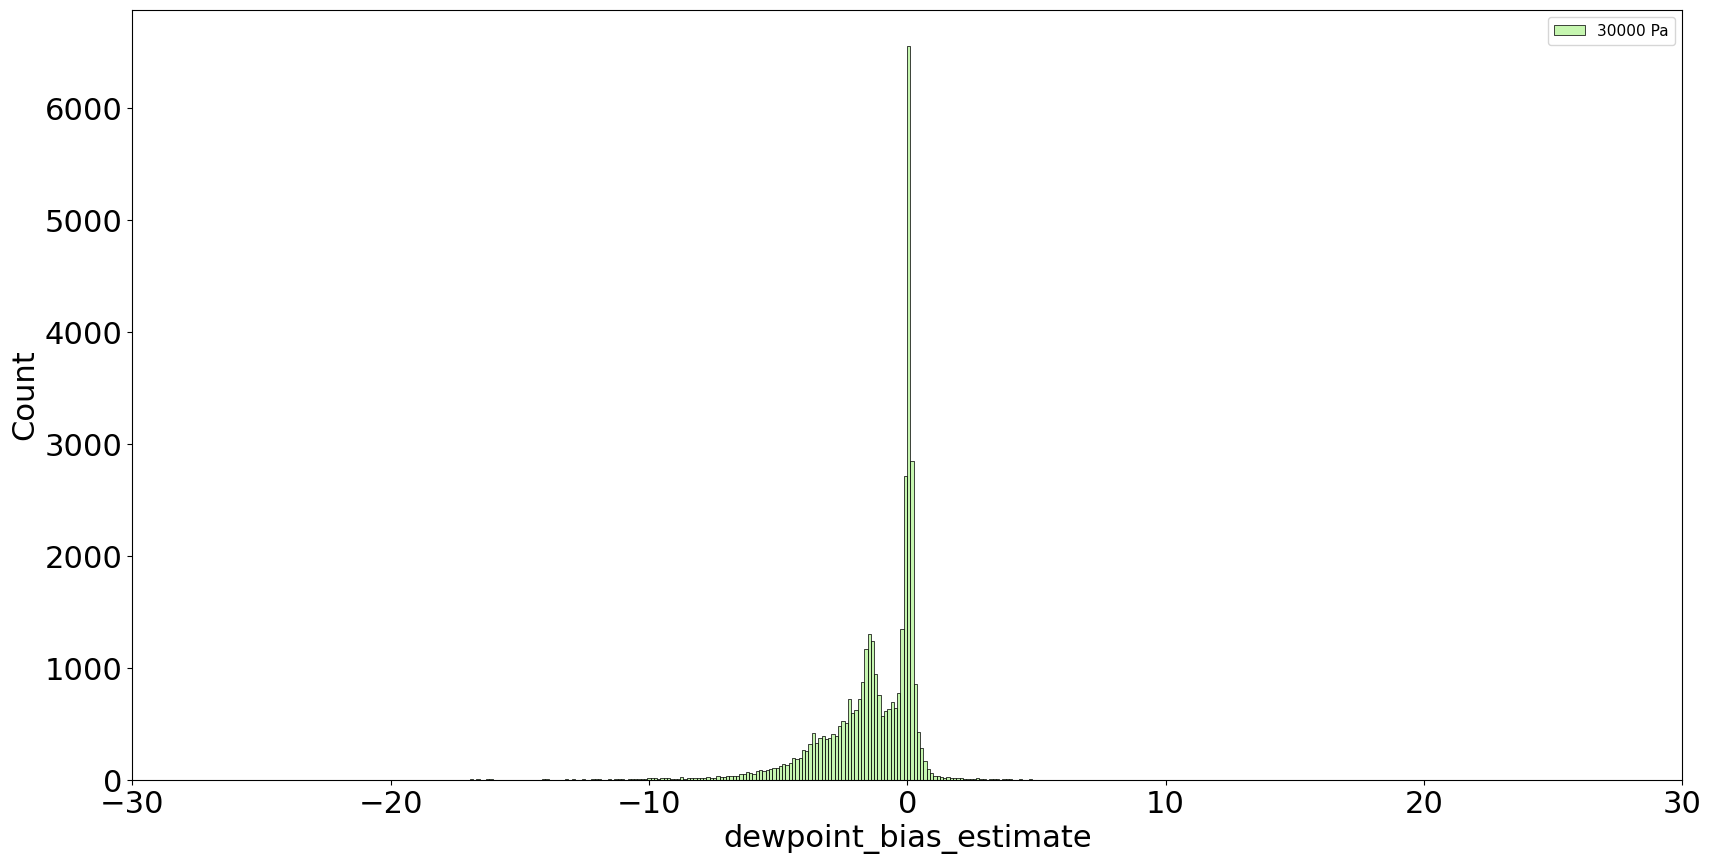

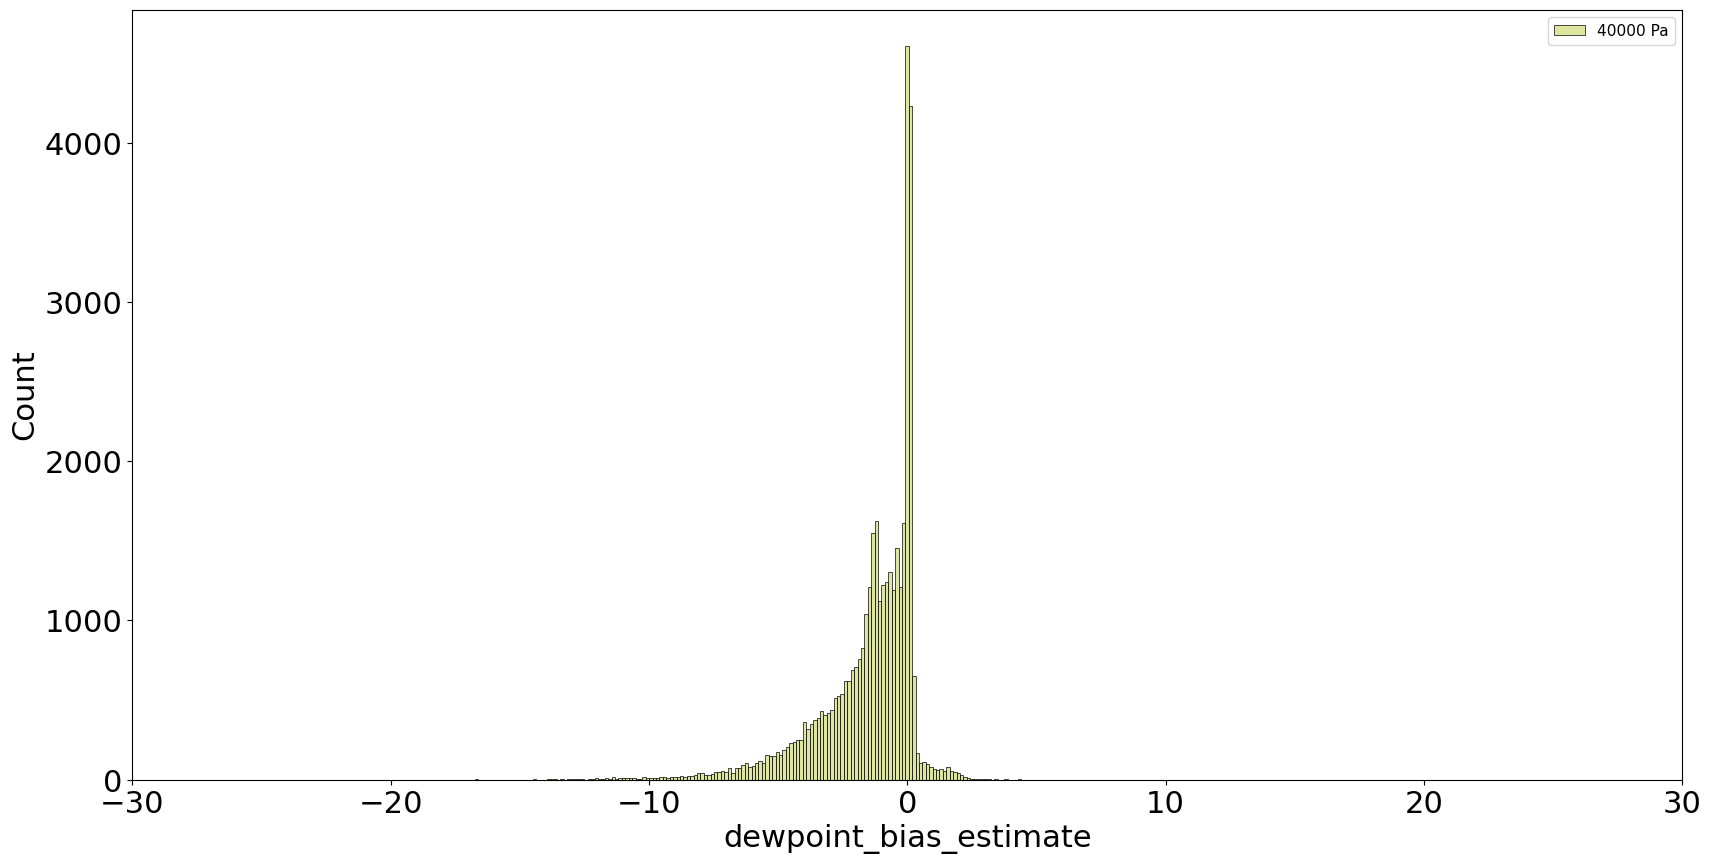

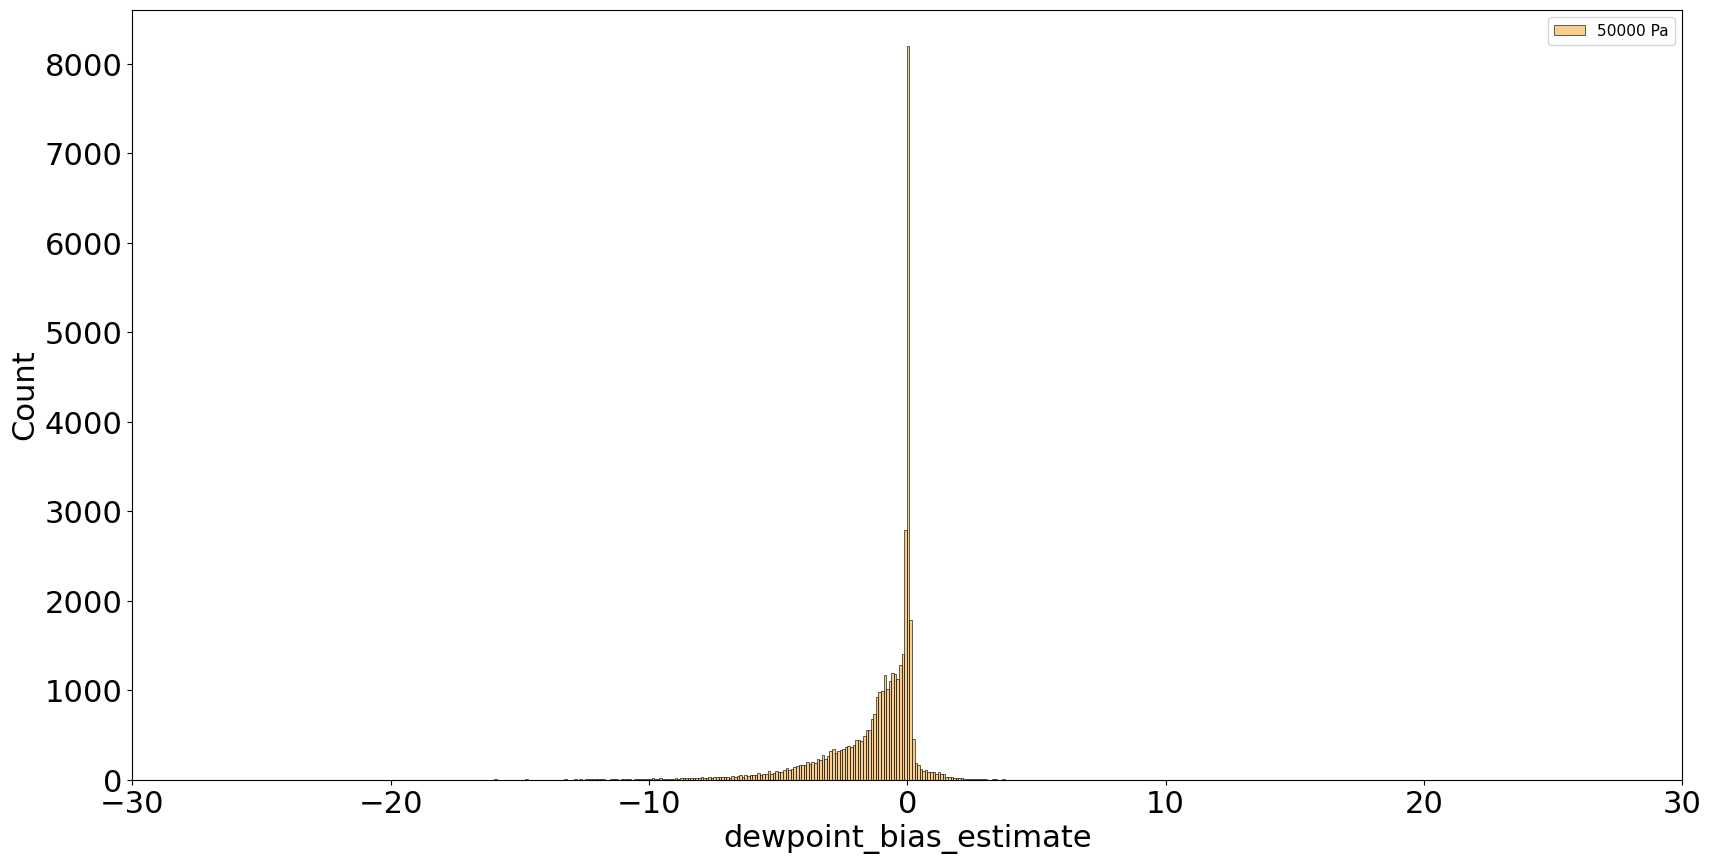

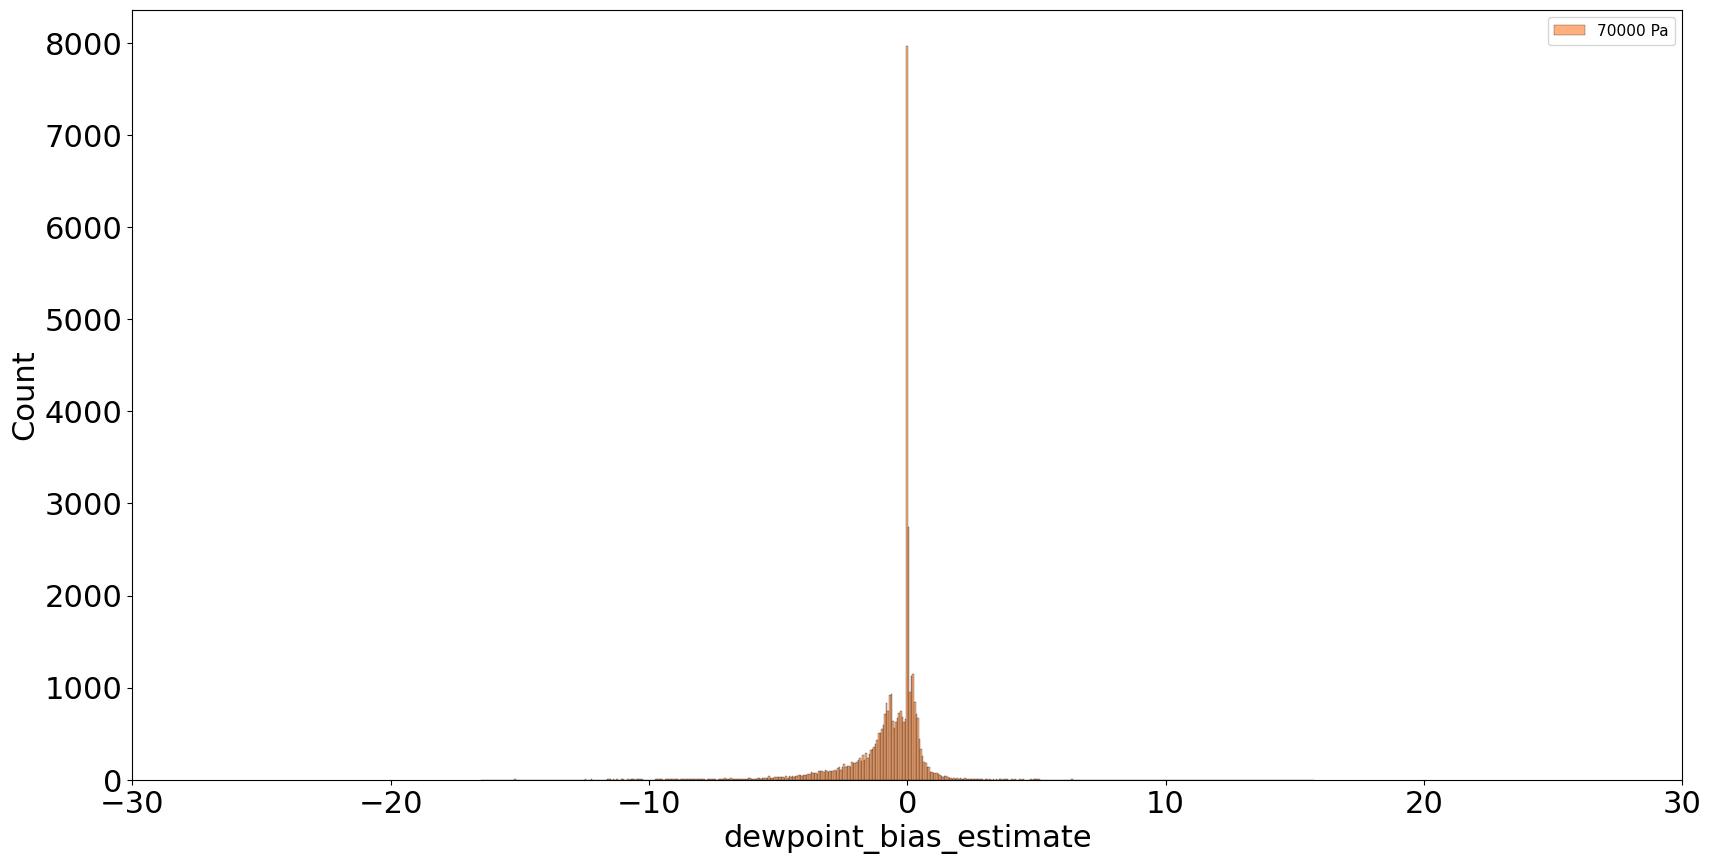

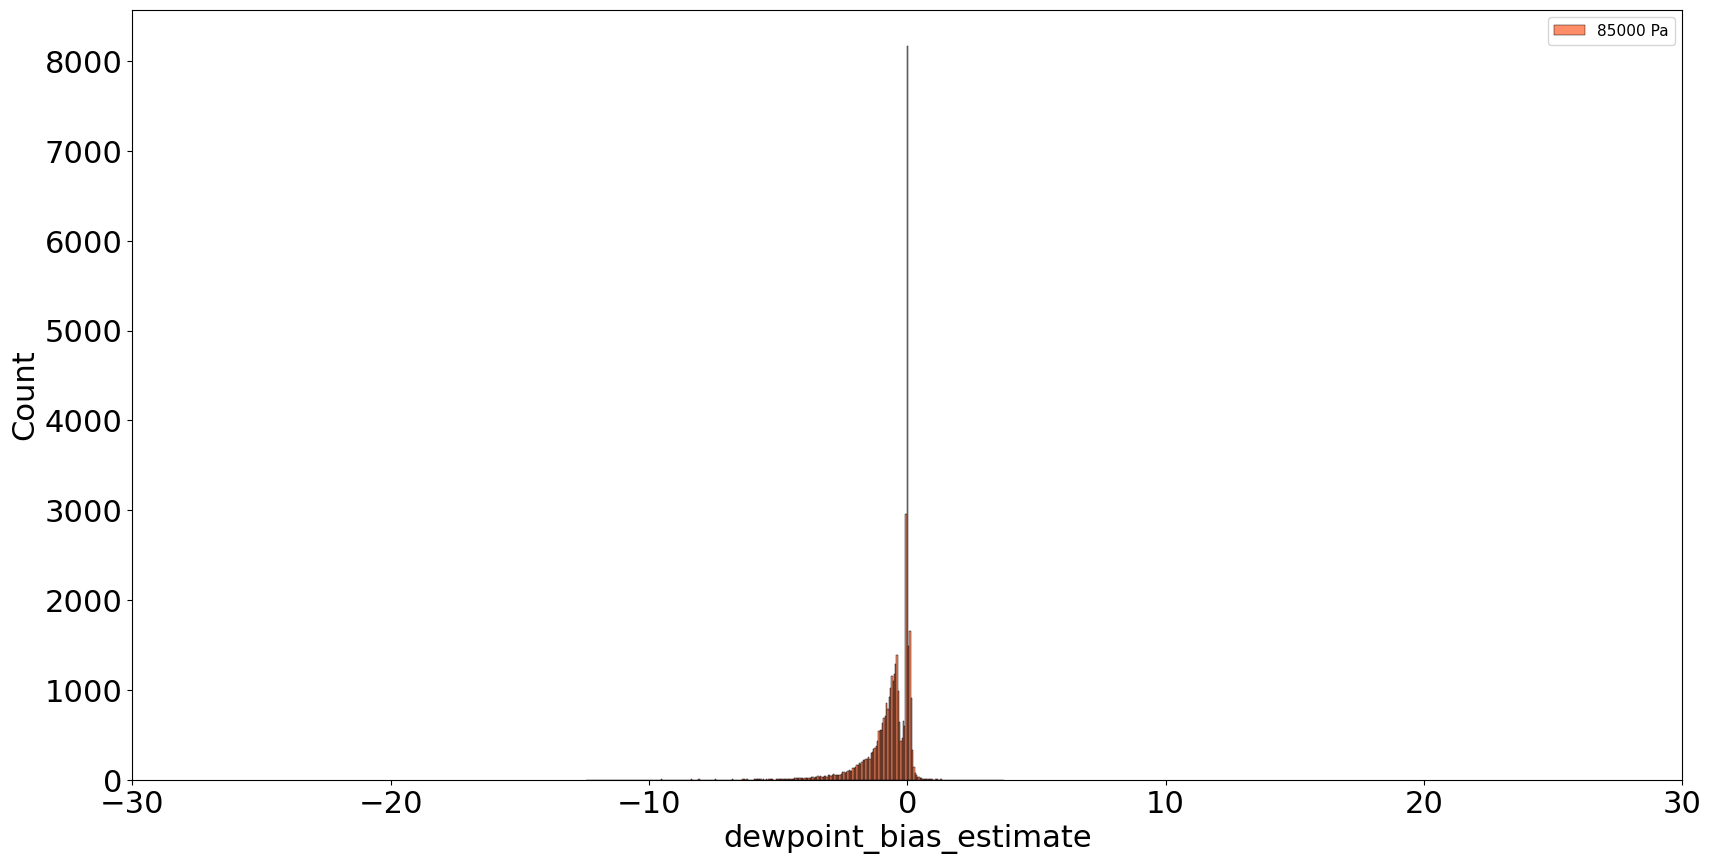

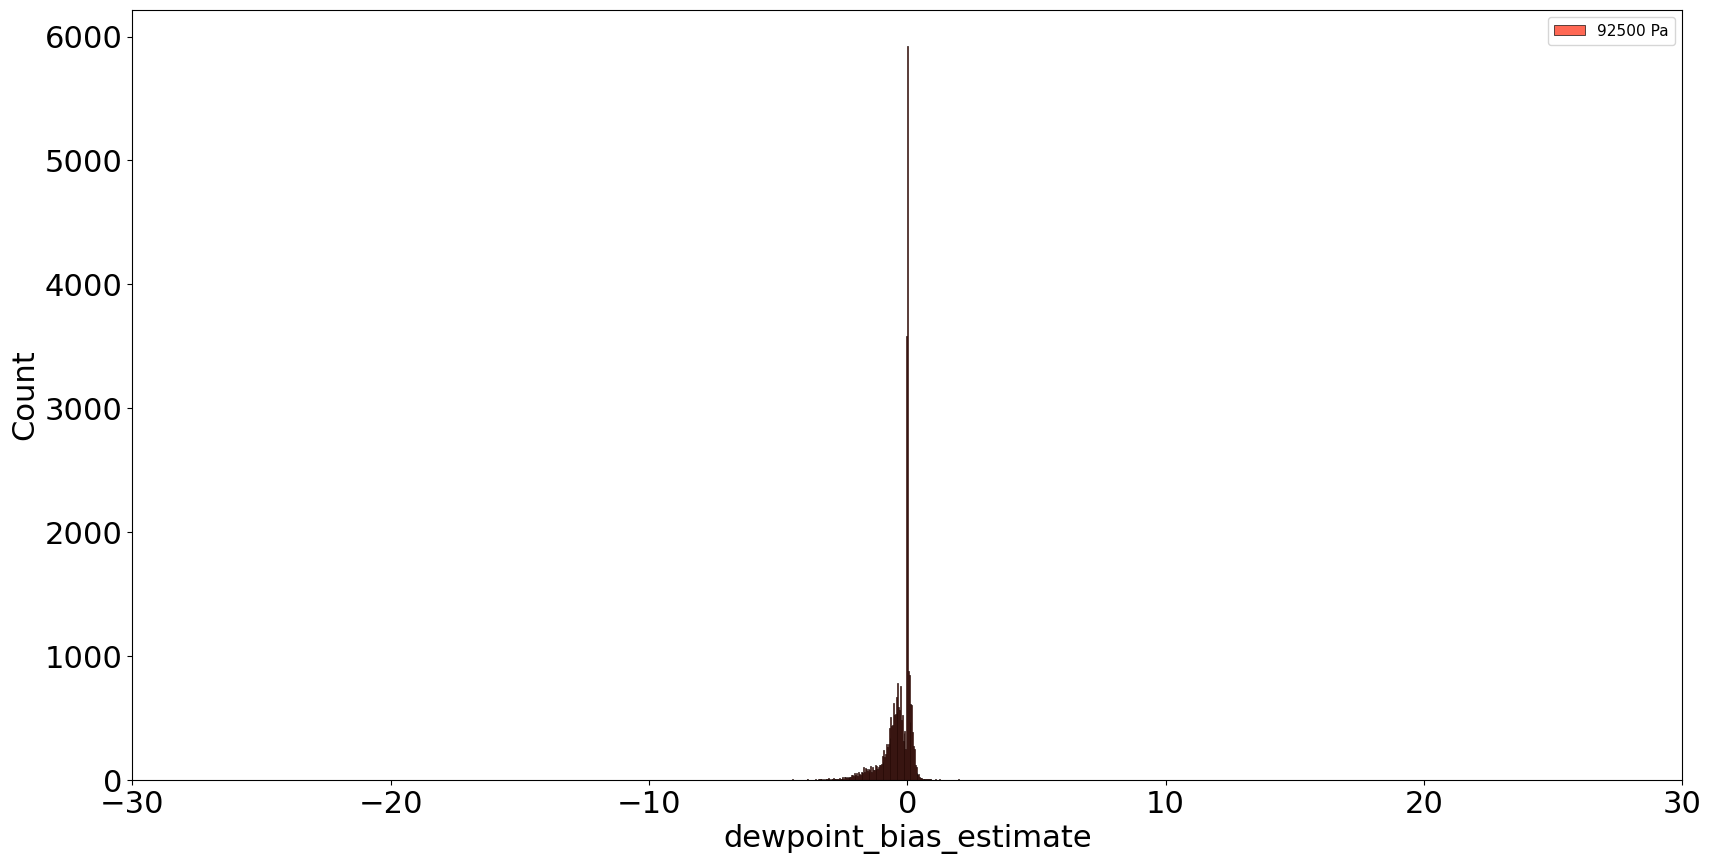

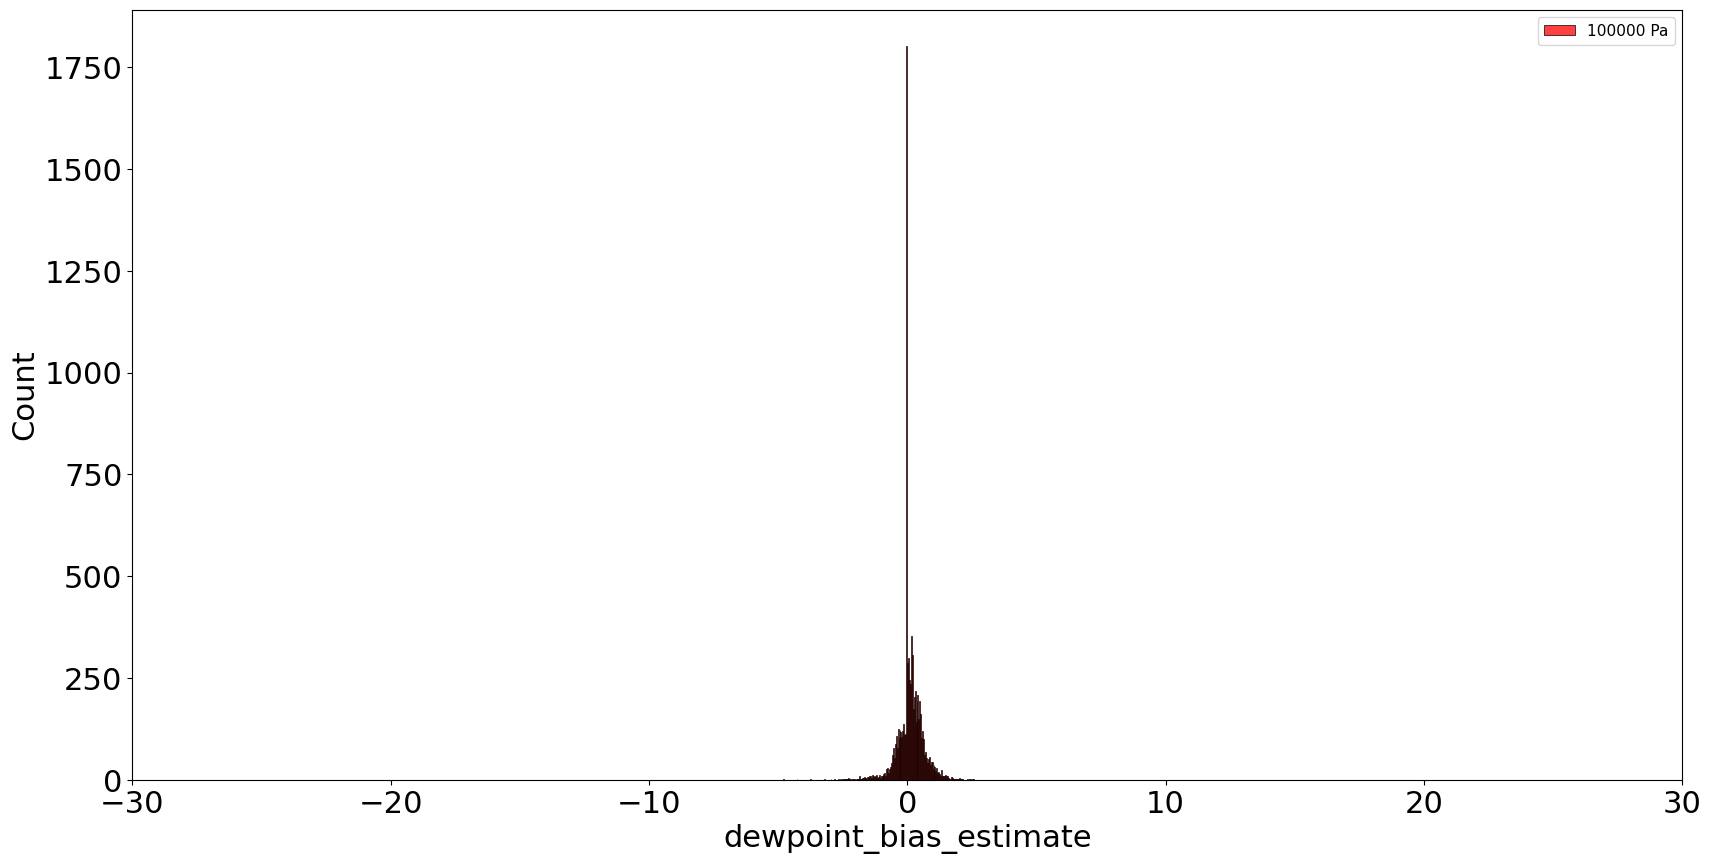

In [48]:
for i in plevs:
    seaborn.histplot(data=df_final[df_final.z_coordinate == i], x="dewpoint_bias_estimate", color=plev_color[i], label = str(i) + ' Pa', legend=False)
font = font_manager.FontProperties(size=11)
plt.legend(prop=font)
plt.xlim(-30, 30)
plt.show()
plt.close()

for i in plevs:
    seaborn.histplot(data=df_final[df_final.z_coordinate == i], x="dewpoint_bias_estimate", color=plev_color[i], label = str(i) + ' Pa', legend=False)
    font = font_manager.FontProperties(size=11)
    plt.legend(prop=font)
    plt.xlim(-30, 30)
    plt.show()
    plt.close()

In [29]:
display(np.count_nonzero(~np.isnan(df_final.adj_dp)))
display(np.count_nonzero(~np.isnan(df_final.dewpoint_bias_estimate)))
display(np.count_nonzero(~np.isnan(df_final.adj_rh)))
display(np.count_nonzero(~np.isnan(df_final.ta)))

11693082

11556198

11711081

11705952

In [30]:
df_final

,rh,adj_rh,z_coordinate,date_time,cm_rh,dp,cm_dp,ta,adj_dp,dewpoint_bias_estimate
0,0.280000,0.280000,4300.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,220.750000,210.479996,NaN
1,0.290000,0.290000,4400.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,220.550003,210.570007,NaN
2,0.280000,0.280000,5300.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,216.250000,206.449997,NaN
3,0.280000,0.280000,9200.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,215.850006,206.089996,NaN
4,0.290000,0.290000,10300.0,1925-01-24 09:22:00,-2147483648,NaN,NaN,220.050003,210.119995,NaN
...,...,...,...,...,...,...,...,...,...,...
11713174,0.792027,0.792027,99440.0,2022-12-31 11:30:23,-2147483648,276.320007,-2.147484e+09,279.660004,276.329987,-0.009979
11713175,0.788326,0.788326,99470.0,2022-12-31 11:30:23,-2147483648,276.390015,-2.147484e+09,279.799988,276.399994,-0.009979
11713176,0.784618,0.784618,99530.0,2022-12-31 11:30:23,-2147483648,276.440002,-2.147484e+09,279.920013,276.450012,-0.010010
11713177,0.782605,0.782605,99540.0,2022-12-31 11:30:23,-2147483648,276.529999,-2.147484e+09,280.049988,276.540009,-0.010010


In [31]:
df_final.cm_rh.drop_duplicates()

0   -2147483648
Name: cm_rh, dtype: int32

In [32]:
df_final.cm_dp.drop_duplicates()

0                 NaN
61082   -2.147484e+09
Name: cm_dp, dtype: float64